# Predicció del preu d'un smartphone

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Importem el dataset
Llegim la nostra base de dades del fitxer csv i la carreguem en un objecte `dataframe` de pandas.

In [3]:
path_file = os.getcwd() + "/smartphone_data.csv"
data = pd.read_csv(path_file)
data.head(5)

brand_name                      model  price  rating  has_5g  has_nfc  \
0    oneplus              OnePlus 11 5G  54999    89.0    True     True   
1    oneplus  OnePlus Nord CE 2 Lite 5G  19989    81.0    True    False   
2    samsung      Samsung Galaxy A14 5G  16499    75.0    True    False   
3   motorola       Motorola Moto G62 5G  14999    81.0    True    False   
4     realme         Realme 10 Pro Plus  24999    82.0    True    False   

   has_ir_blaster processor_brand  num_cores  processor_speed  ...  \
0           False      snapdragon        8.0              3.2  ...   
1           False      snapdragon        8.0              2.2  ...   
2           False          exynos        8.0              2.4  ...   
3           False      snapdragon        8.0              2.2  ...   
4           False       dimensity        8.0              2.6  ...   

   screen_size  refresh_rate    resolution  num_rear_cameras  \
0         6.70           120  1440 x 3216                  3   
1         6.59           120  1080 x 2412                  3   
2         6.60            90  1080 x 2408                  3   
3         6.55           120  1080 x 2400                  3   
4         6.70           120  1080 x 2412                  3   

   num_front_cameras       os  primary_camera_rear primary_camera_front  \
0                1.0  android                 50.0                 16.0   
1                1.0  android                 64.0                 16.0   
2                1.0  android                 50.0                 13.0   
3                1.0  android                 50.0                 16.0   
4                1.0  android                108.0                 16.0   

   extended_memory_available  extended_upto  
0                          0            NaN  
1                          1         1024.0  
2                          1         1024.0  
3                          1         1024.0  
4                          0            NaN  

[5 rows x 25 columns]

## Comprovació de valors mancants i descripcció de les dades
Comprovem quants **NA** tenim al nostre dataset per a poder veure amb quines dades estem treballant. A més inspeccionem el tipus de variables que conté el dataset utilitzant el mètode `info`.

In [4]:
data.isna().sum()

brand_name                     0
model                          0
price                          0
rating                       101
has_5g                         0
has_nfc                        0
has_ir_blaster                 0
processor_brand               20
num_cores                      6
processor_speed               42
battery_capacity              11
fast_charging_available        0
fast_charging                211
ram_capacity                   0
internal_memory                0
screen_size                    0
refresh_rate                   0
resolution                     0
num_rear_cameras               0
num_front_cameras              4
os                            14
primary_camera_rear            0
primary_camera_front           5
extended_memory_available      0
extended_upto                480
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand_name                 980 non-null    object 
 1   model                      980 non-null    object 
 2   price                      980 non-null    int64  
 3   rating                     879 non-null    float64
 4   has_5g                     980 non-null    bool   
 5   has_nfc                    980 non-null    bool   
 6   has_ir_blaster             980 non-null    bool   
 7   processor_brand            960 non-null    object 
 8   num_cores                  974 non-null    float64
 9   processor_speed            938 non-null    float64
 10  battery_capacity           969 non-null    float64
 11  fast_charging_available    980 non-null    int64  
 12  fast_charging              769 non-null    float64
 13  ram_capacity               980 non-null    float64

# Preprocessament
Fem `drop` de fast charging i de model ja que fast charging no aporta informació extra respecte a fast_charging_available i model té un nom únic per a cada mòbil.

In [6]:
data.drop(columns = ["fast_charging"], inplace = True)
data.drop(columns = ["model"], inplace = True)

## Matriu de correlació de les nostres variables numèriques sense preprocessar
Fem el plot de la matriu de correlació per a veure que les nostres dades numèriques no tenen molta correlació entre elles, en el cas d'haver-hi dues o més variables molt correlacionades, s'hauria de tractar eliminant una de les columnes o fusionant aquestes.

Per sort podem veure que cada una de les nostres variables aporta una informació diferent al nostre dataset, i que per tant totes poden ser utilitzades per a la predicció de la nostra variable target **price**.

<Axes: >

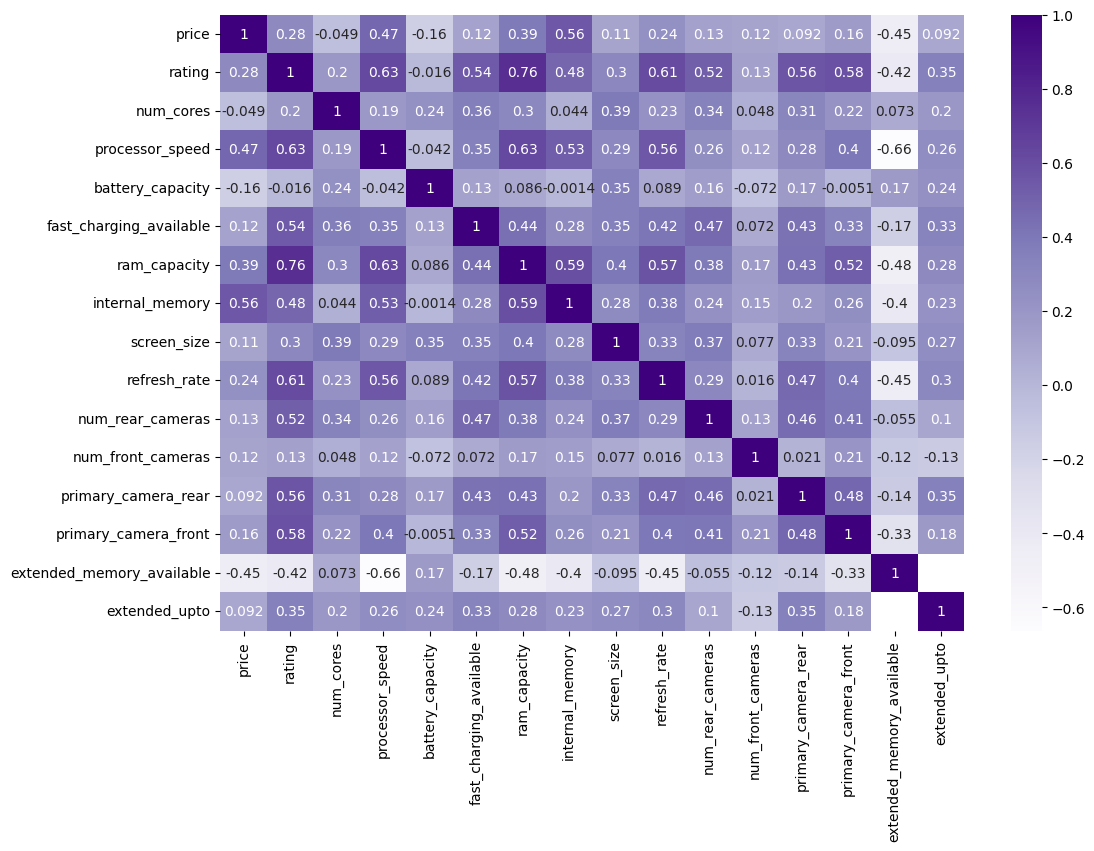

In [7]:
data_num = data.select_dtypes(include = [np.number])
cor = data_num.corr()

plt.figure(figsize = (12, 8))
sns.heatmap(cor, annot = True, cmap = plt.cm.Purples)

## Visualitzem les distribucions de les nostres variables numèriques
Observem que les distribucions de les nostres variables numèriques, en el procés descobrim que algunes de les variables que pandas havia detectat resulten ser categòriques o binàries, com ara **fast_charging_available** o **num_rear_cameras**, que hauran de ser reconvertides posteriorment. Observant la resta de distribucions, podem veure la presència d'outliers que dificulten la visualització de les dades, aquests hauran de ser tractats posteriorment.

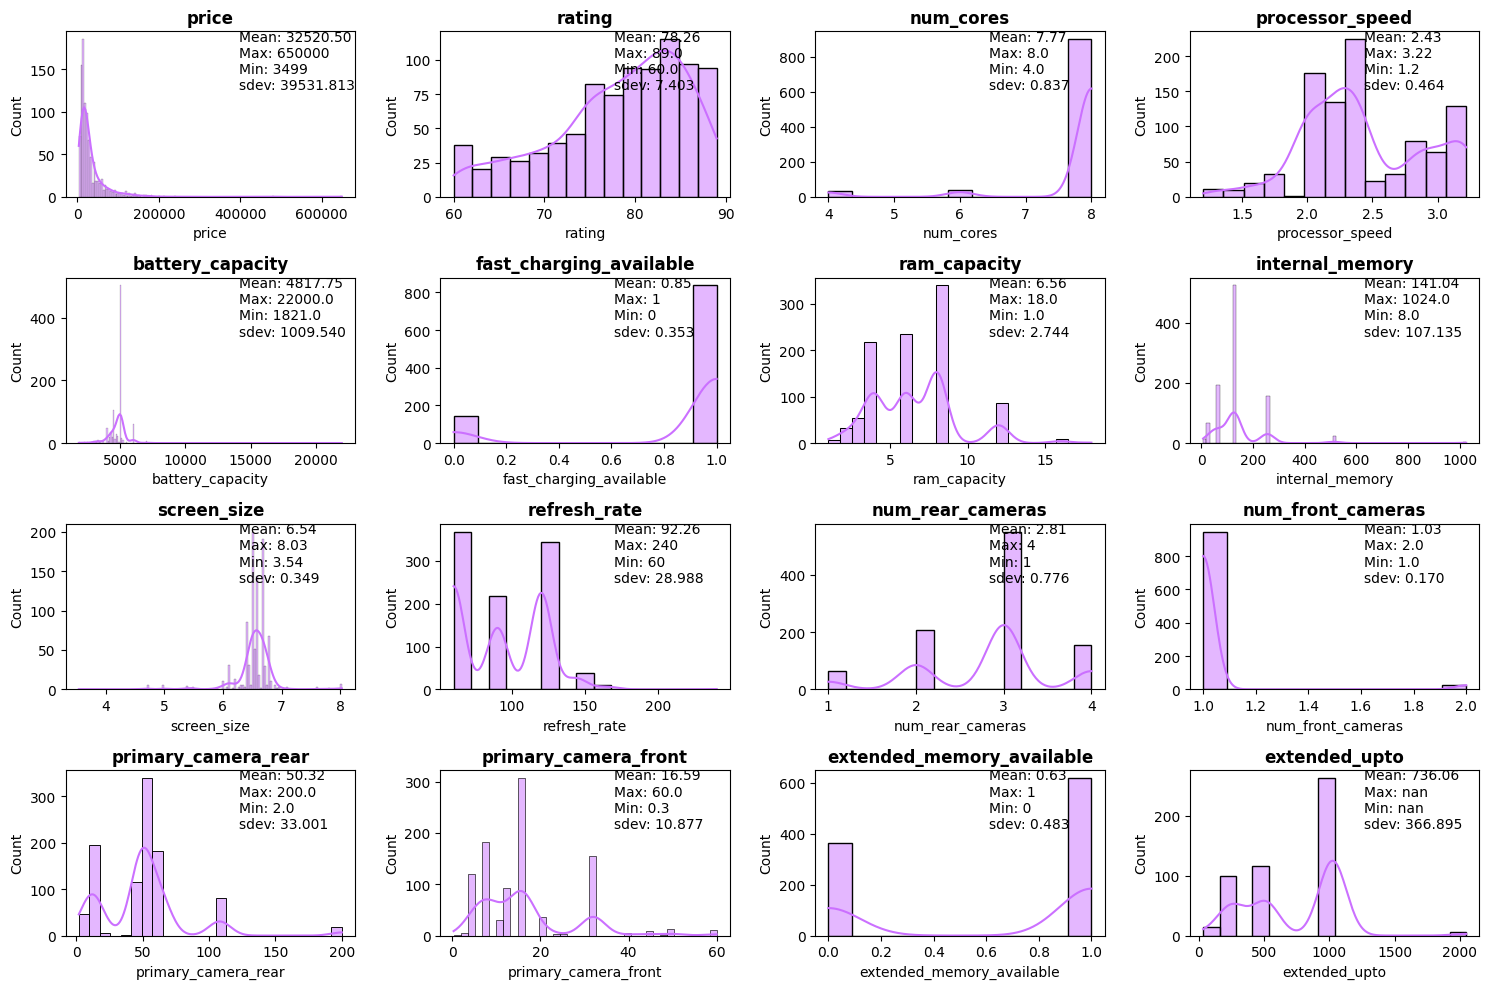

In [8]:
numericals = data_num.columns

fig, axs = plt.subplots(4, 4, figsize=(15, 10))  #creem un subplot per a poder veure totes les gràfiques juntes
axs = axs.ravel()  

for i, column in enumerate(numericals):
    column_treated = pd.to_numeric(data[column], errors='coerce')
    mitjana = column_treated.mean()
    sns.histplot(data_num[column], kde=True, ax=axs[i], color="#cb70ff")
    axs[i].set_title(column, fontweight="bold")
    axs[i].text(0.6, 0.65, f"Mean: {mitjana:.2f}\nMax: {max(data[column])} \nMin: {min(data[column])} \nsdev: {column_treated.std():.3f}", transform=axs[i].transAxes)  # Use transAxes to position text

plt.tight_layout()  
plt.show()

## Fem els barplots de les nostres variables categòriques
Observant els barplots podem trobar un clar desbalanceig de dades en bastantes de les nostres variables, com ara a la de sistema operatiu, en la que iOS presenta un valor molt més baix que android, o a has_ir_blaster. En canvi les altres variables es troben amb una partició de valors correcta. Però hem de tenir en compte el desbalanceig a l'hora de fer la partició i estudiar els resultats d'aquesta amb els diferents models que utilitzarem.

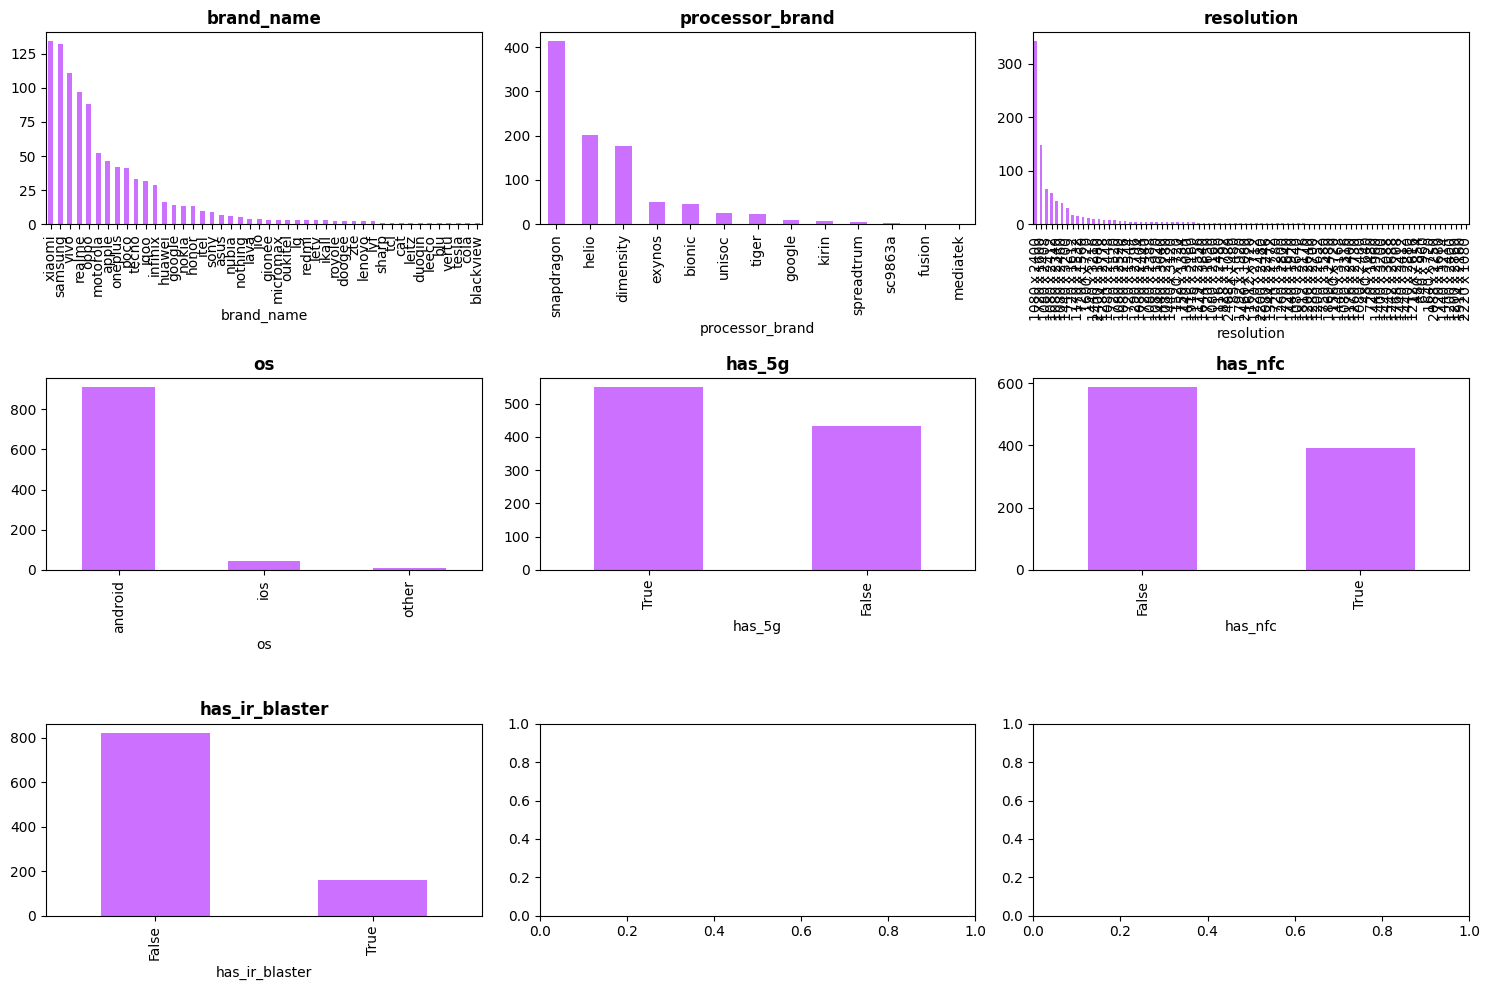

In [9]:
categoricals = data.select_dtypes(include=[object]).columns 
categoricals = pd.Index(categoricals)
categoricals = categoricals.append(pd.Index(["has_5g","has_nfc","has_ir_blaster"]))

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  
axs = axs.ravel()  

for i, column in enumerate(categoricals):
    data[column].value_counts().plot(kind='bar', ax=axs[i], color = "#cb70ff")
    axs[i].set_title(column, fontweight="bold")

plt.tight_layout()  
plt.show()

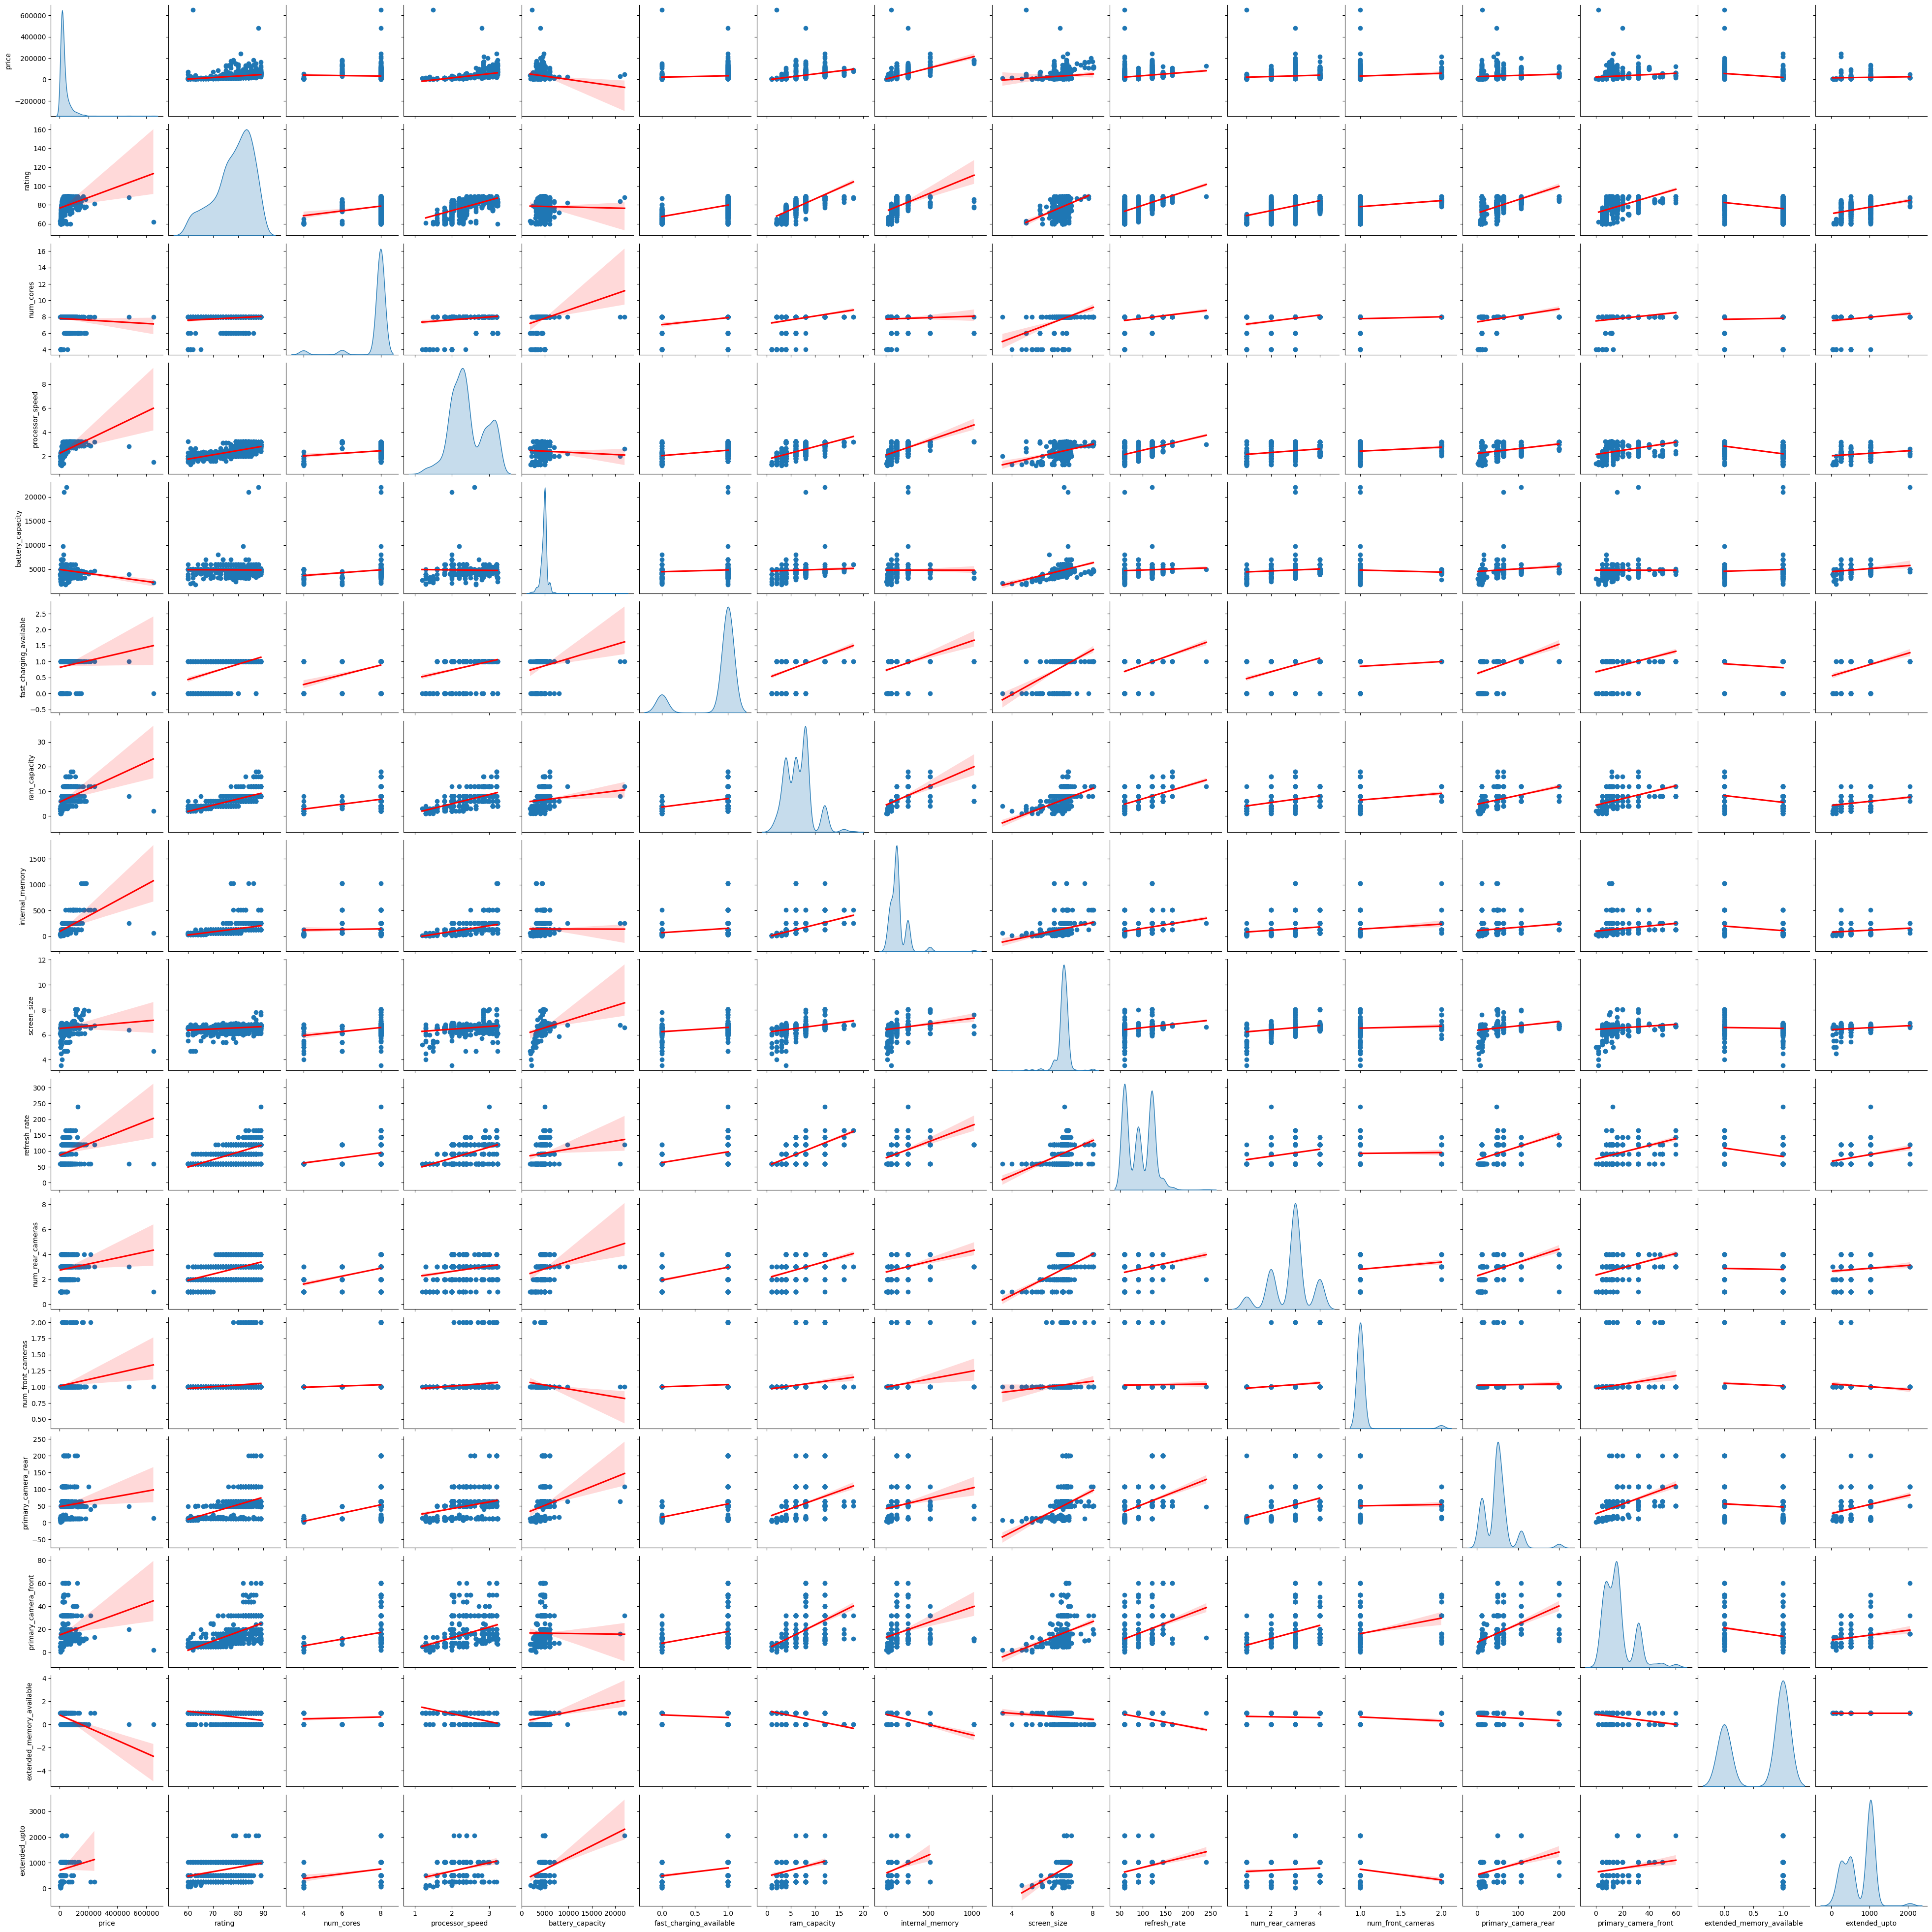

In [10]:
sns.pairplot(data[numericals], diag_kind="kde", kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 1}})

## Tractem les variables que puguin presentar problemes
En aquest apartat farem una neteja de les variables que continguin molts valors, o valors que no ens afavoreixin a l'enteniment del nostre model.

### Tractament de la variable "processor_brand"
Donat que processor_brand té molts possibles valors, hem decidit quedar-nos només amb aquelles marques de processadors que tinguin més de 60 dispositius dins de la nostra base de dades, i classificar a la resta com a **other** per a simplificar el nostre model.

In [11]:
data2 = data.copy()

count = data2['processor_brand'].value_counts()
mask = data2['processor_brand'].isin(count[count < 60].index)
data2.loc[mask, 'processor_brand'] = 'others'

In [12]:
print(data2['processor_brand'].value_counts())

processor_brand
snapdragon    413
helio         201
dimensity     177
others        169
Name: count, dtype: int64


### Tractament de la variable "resolution"
Per a resolution, hem decidit passar de una variable categòrica amb molts possibles valors, a una de numèrica que expressa el nombre de pixels que té cada mòbil a la pantalla, d'aquesta forma conservem molta de la informació i interpretabilitat, però facilitem la feina al model.

In [13]:
def calculate_pixels(resolution):
    width, height = resolution.split('x')
    return int(width) * int(height)

data2['resolution'] = data2['resolution'].apply(calculate_pixels)
data2['resolution'] = pd.to_numeric(data2['resolution'])
data2 = data2.rename(columns={'resolution': 'number_pixels'})

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand_name                 980 non-null    object 
 1   price                      980 non-null    int64  
 2   rating                     879 non-null    float64
 3   has_5g                     980 non-null    bool   
 4   has_nfc                    980 non-null    bool   
 5   has_ir_blaster             980 non-null    bool   
 6   processor_brand            960 non-null    object 
 7   num_cores                  974 non-null    float64
 8   processor_speed            938 non-null    float64
 9   battery_capacity           969 non-null    float64
 10  fast_charging_available    980 non-null    int64  
 11  ram_capacity               980 non-null    float64
 12  internal_memory            980 non-null    float64
 13  screen_size                980 non-null    float64

### Tractament de la variable "brand_name"
Donat que brand_name té molts possibles valors, hem decidit quedar-nos només amb aquelles marques de processadors que tinguin més de 40 dispositius dins de la nostra base de dades, i classificar a la resta com a **other** per a simplificar el nostre model.

In [14]:
print(data2['brand_name'].value_counts())

brand_name
xiaomi       134
samsung      132
vivo         111
realme        97
oppo          88
motorola      52
apple         46
oneplus       42
poco          41
tecno         33
iqoo          32
infinix       29
huawei        16
google        14
nokia         13
honor         13
itel          10
sony           9
asus           7
nubia          6
nothing        5
lava           4
jio            4
gionee         3
micromax       3
oukitel        3
lg             3
redmi          3
letv           3
ikall          3
royole         2
doogee         2
zte            2
lenovo         2
lyf            2
sharp          1
tcl            1
cat            1
leitz          1
duoqin         1
leeco          1
blu            1
vertu          1
tesla          1
cola           1
blackview      1
Name: count, dtype: int64


In [15]:
count = data2['brand_name'].value_counts()
mask = data2['brand_name'].isin(count[count < 40].index)
data2.loc[mask, 'brand_name'] = 'others'
print(data2['brand_name'].value_counts())

brand_name
others      237
xiaomi      134
samsung     132
vivo        111
realme       97
oppo         88
motorola     52
apple        46
oneplus      42
poco         41
Name: count, dtype: int64


### Convertim a categoriques les següents variables
En aquest bloc convertim totes les variables que havien sigut classificades erròniament com a numèriques a categòriques.

In [16]:
to_categorical = ["refresh_rate", "num_rear_cameras","num_front_cameras","extended_memory_available","fast_charging_available","num_cores"]
for col in to_categorical:
    data2[col] = data2[col].astype('category')
data2.head(10)


brand_name  price  rating  has_5g  has_nfc  has_ir_blaster processor_brand  \
0    oneplus  54999    89.0    True     True           False      snapdragon   
1    oneplus  19989    81.0    True    False           False      snapdragon   
2    samsung  16499    75.0    True    False           False          others   
3   motorola  14999    81.0    True    False           False      snapdragon   
4     realme  24999    82.0    True    False           False       dimensity   
5    samsung  16999    80.0    True     True           False      snapdragon   
6      apple  65999    81.0    True     True           False          others   
7     xiaomi  29999    86.0    True    False            True       dimensity   
8     others  26749    85.0    True     True           False      snapdragon   
9    oneplus  28999    84.0    True     True           False       dimensity   

  num_cores  processor_speed  battery_capacity  ... screen_size  refresh_rate  \
0       8.0             3.20            5000.0  ...        6.70           120   
1       8.0             2.20            5000.0  ...        6.59           120   
2       8.0             2.40            5000.0  ...        6.60            90   
3       8.0             2.20            5000.0  ...        6.55           120   
4       8.0             2.60            5000.0  ...        6.70           120   
5       8.0             2.20            5000.0  ...        6.60           120   
6       6.0             3.22            3279.0  ...        6.10            60   
7       8.0             2.60            4980.0  ...        6.67           120   
8       8.0             2.50            4500.0  ...        6.55           120   
9       8.0             3.00            4500.0  ...        6.43            90   

   number_pixels  num_rear_cameras num_front_cameras       os  \
0        4631040                 3               1.0  android   
1        2604960                 3               1.0  android   
2        2600640                 3               1.0  android   
3        2592000                 3               1.0  android   
4        2604960                 3               1.0  android   
5        2600640                 3               1.0  android   
6        2962440                 2               1.0      ios   
7        2592000                 3               1.0  android   
8        2592000                 2               1.0  android   
9        2592000                 3               1.0  android   

  primary_camera_rear primary_camera_front extended_memory_available  \
0                50.0                 16.0                         0   
1                64.0                 16.0                         1   
2                50.0                 13.0                         1   
3                50.0                 16.0                         1   
4               108.0                 16.0                         0   
5                50.0                  8.0                         1   
6                12.0                 12.0                         0   
7               200.0                 16.0                         0   
8                50.0                 16.0                         0   
9                50.0                 32.0                         0   

   extended_upto  
0            NaN  
1         1024.0  
2         1024.0  
3         1024.0  
4            NaN  
5         1024.0  
6            NaN  
7            NaN  
8            NaN  
9            NaN  

[10 rows x 23 columns]

## Tractament dels outliers
En aquest apartat tractarem i observarem els outliers que presenta la nostra base de dades per a poder decidir quin és el procediment correcte per a millorar la precisió del nostre model sense perdre dades.

El primer que farem serà fer boxplots de totes les nostres variables numèriques, d'aquesta forma podrem observar si hi ha presència d'outliers, i en aquest cas, veure en quines variables hi son més presents.

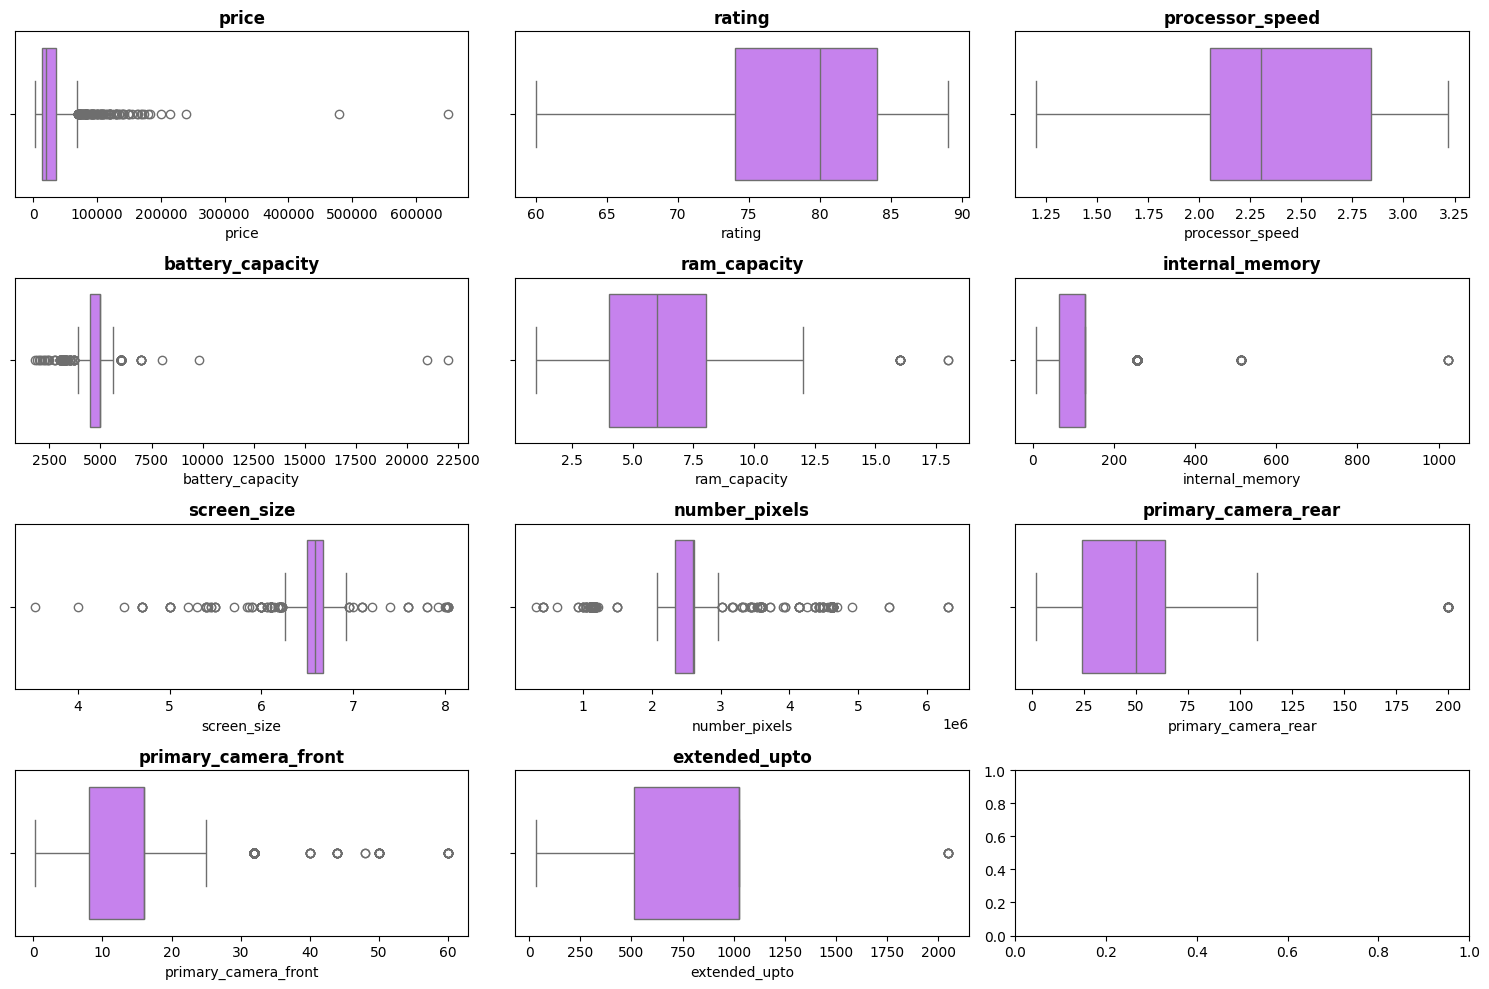

In [17]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))  
axs = axs.ravel()  
numericals = data2.select_dtypes(include=[np.number]).columns
for i, column in enumerate(numericals):
    column_treated = pd.to_numeric(data2[column], errors='coerce').dropna()
    sns.boxplot(x=column_treated, ax=axs[i], color = "#cb70ff")
    axs[i].set_title(column, fontweight="bold")

plt.tight_layout()  
plt.show()

### Observem aquelles variables que presenten els outliers més extrems

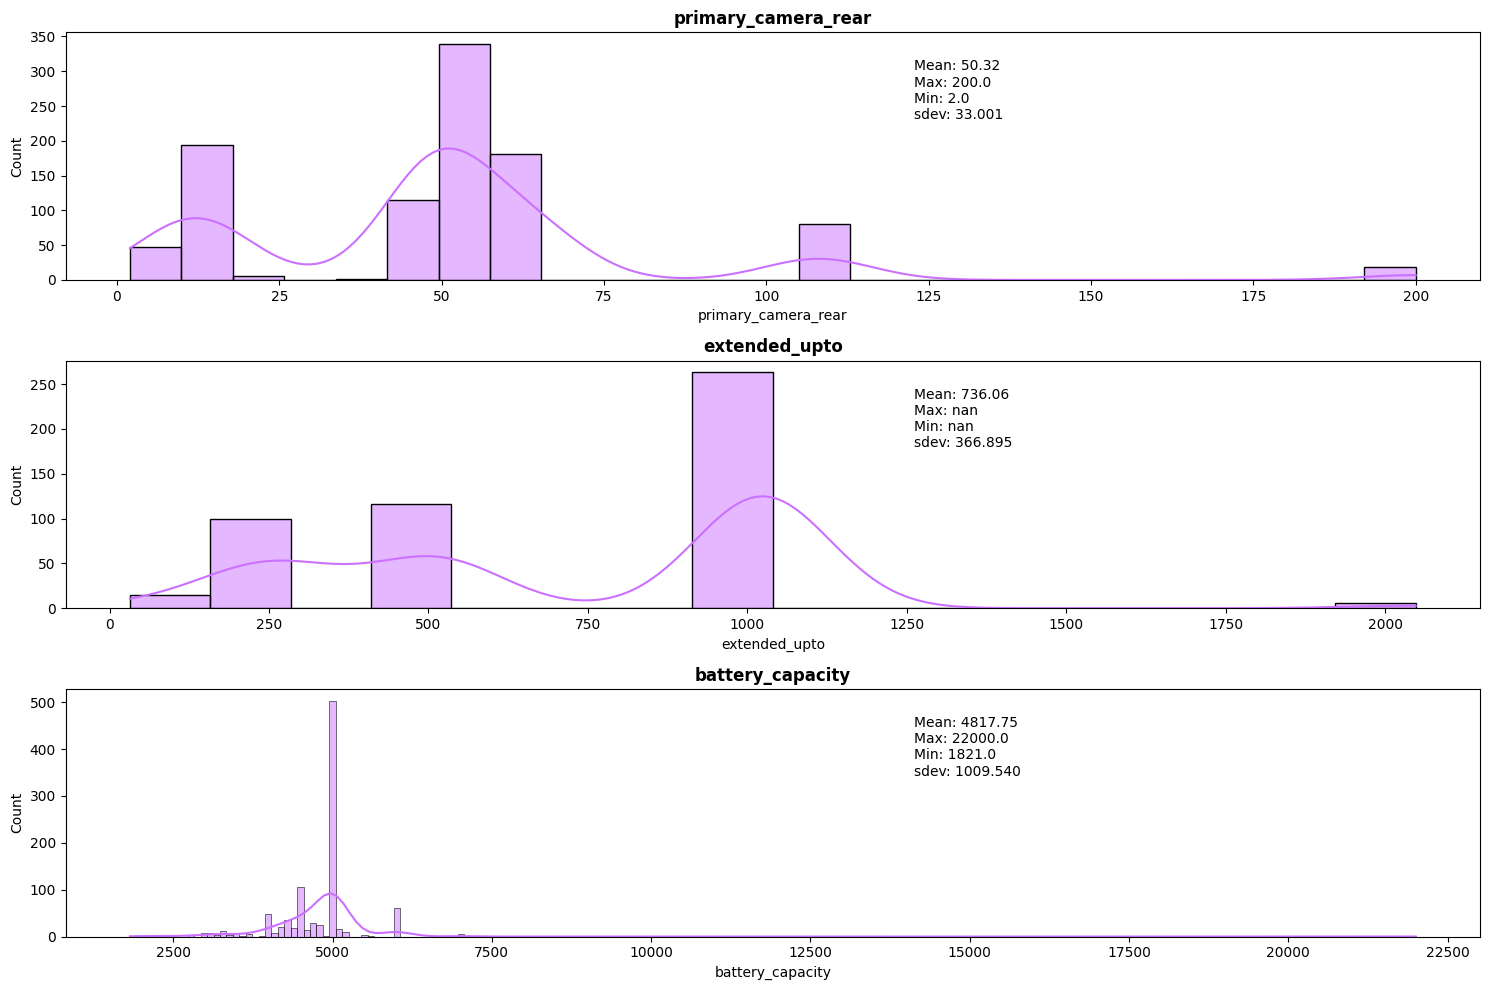

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))  # Adjust grid size and figure size as needed
axs = axs.ravel()  # Flatten the array of axes
selected = ["primary_camera_rear","extended_upto","battery_capacity"]
for i, column in enumerate(selected):
    column_treated = pd.to_numeric(data2[column], errors='coerce')
    mitjana = column_treated.mean()
    sns.histplot(data_num[column], kde=True, ax=axs[i], color="#cb70ff")
    axs[i].set_title(column, fontweight="bold")
    axs[i].text(0.6, 0.65, f"Mean: {mitjana:.2f}\nMax: {max(data2[column])} \nMin: {min(data2[column])} \nsdev: {column_treated.std():.3f}", transform=axs[i].transAxes)  # Use transAxes to position text

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

### PCA de les nostres dades per trobar outliers
Realitzem un PCA combinat amb una isolation forest per a trobar els punts més desconnectats de la resta de dades, però com no podem interpretar tant bé quins son aquests outliers, optem per a eliminar-los utilitzant el rang interquartil, ja que d'aquesta forma podem saber exactament de quina fila i de quina variable és el valor, i consecuentment prendre una millor decisió sobre si eliminar aquest o no.

(452, 3)
(980, 23)
(980, 23)
Number of outliers: 23


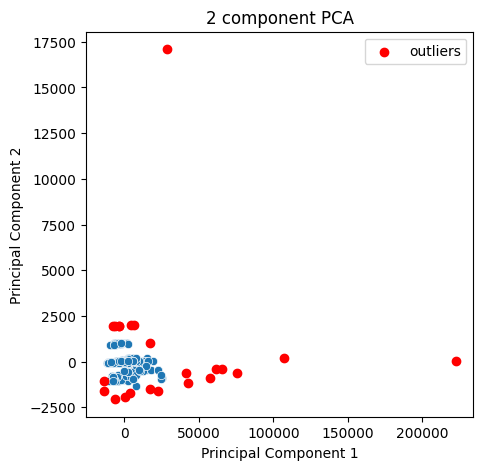

In [19]:
pca = PCA(n_components=2)
pca.fit(data_num.dropna())
data_pca = pca.transform(data_num.dropna())
data_pca = pd.DataFrame(data_pca, columns=['pca1', 'pca2'])

clf = IsolationForest(random_state=0,contamination=0.05)
clf.fit(data_pca)
outliers = clf.predict(data_pca)
data_pca['outliers'] = outliers

print(data_pca.shape)
print(data2.shape)
# Get the indices of the outliers
outlier_indices = data_pca[data_pca['outliers'] == -1].index

# Drop the 
print(data2.shape)

# plot the data
plt.figure(figsize=(5, 5))
sns.scatterplot(x='pca1', y='pca2', data=data_pca)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
# plot the outliers
outliers = data_pca[data_pca['outliers'] == -1]
plt.scatter(outliers['pca1'], outliers['pca2'], color='red', label='outliers')
# print the number of outliers
print(f'Number of outliers: {len(outliers)}')
plt.legend()
plt.show()


## Indentifiquem outliers amb IQR
Hem escollit un IQR de 0.1 a 0.9, ja que d'aquesta forma eliminem aquells outliers més extrems sense danyar massa a les nostres dades, hem cregut que així no perdíem massa informació.

A més d'això, hem decidit canviar els outliers per NA, ja que d'aquesta forma els podrem imputar utilitznt KNN posteriorment.

In [20]:
# using IQR to remove outliers
Q1 = data2.select_dtypes(include=[np.number]).quantile(0.1)
Q3 = data2.select_dtypes(include=[np.number]).quantile(0.9)
IQR = Q3 - Q1
# count the number of outliers
outliers = (data2.select_dtypes(include=[np.number]) < (Q1 - 1.5 * IQR)) | (data2.select_dtypes(include=[np.number]) > (Q3 + 1.5 * IQR))
print(outliers.sum())


price                   12
rating                   0
processor_speed          0
battery_capacity        18
ram_capacity            11
internal_memory          5
screen_size             38
number_pixels            0
primary_camera_rear     18
primary_camera_front     0
extended_upto            0
dtype: int64


In [21]:
# set the rows that contain outliers to NaN
data2[outliers.any(axis=1)] = pd.NA

C:\Users\Edu\AppData\Local\Temp\ipykernel_12884\2787017568.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data2[outliers.any(axis=1)] = pd.NA


## Estudi dels missing values
En la següent gràfica podem veure els outliers que hem eliminat, però també podem observar que la variable extended_upto presenta una gran quantitat de missing data, és per axiò que hem decidit eliminar-la.

<Axes: >

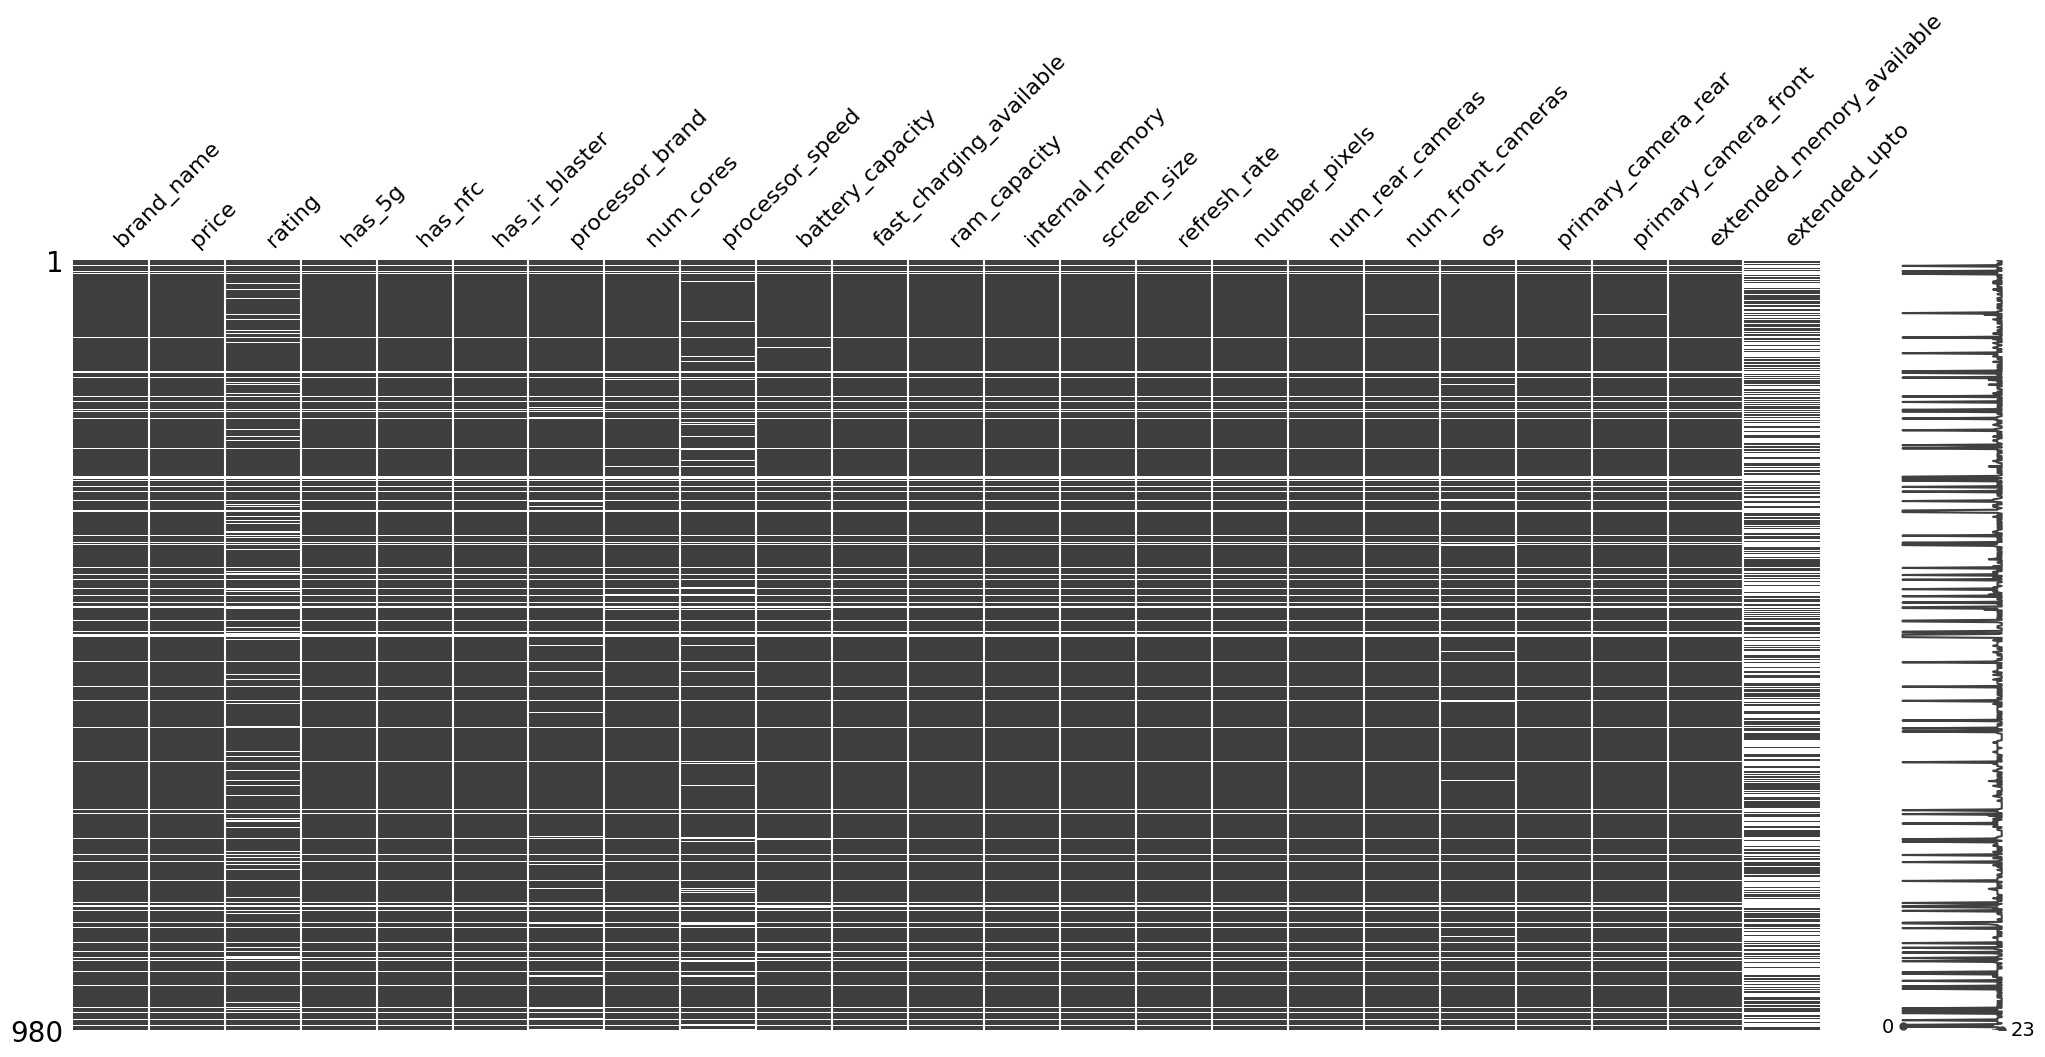

In [22]:
import missingno as msno
msno.matrix(data2)

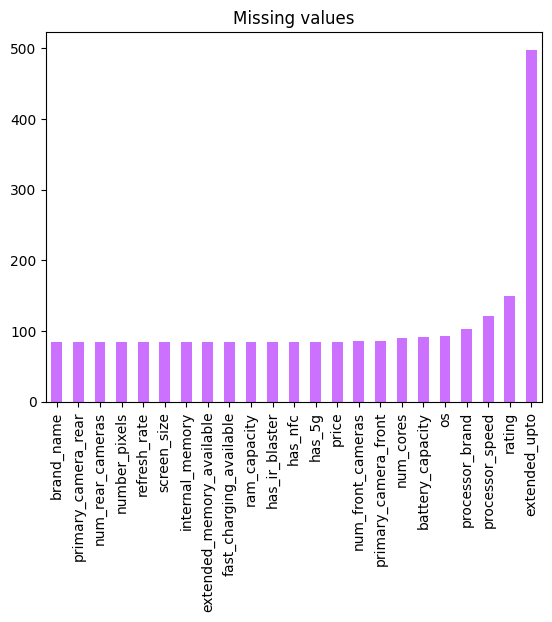

In [23]:
# plot with the missing values
missing = data2.isna().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="#cb70ff")
plt.title("Missing values")
plt.show()

In [24]:
# fem drop de extended_upto ja que te una gran quantitat de missing values
data2.drop(columns = ["extended_upto"], inplace = True)

## Convertim les variables categòriques en numèriques

In [25]:
categoricals = ['brand_name', 'processor_brand', 'os', 'has_5g',
       'has_nfc', 'has_ir_blaster']

### Apliquem one-hot encoding

In [26]:
data3 = pd.get_dummies(data2, columns=categoricals)
data3.head(5)

price  rating num_cores  processor_speed  battery_capacity  \
0  54999.0    89.0       8.0              3.2            5000.0   
1  19989.0    81.0       8.0              2.2            5000.0   
2  16499.0    75.0       8.0              2.4            5000.0   
3  14999.0    81.0       8.0              2.2            5000.0   
4  24999.0    82.0       8.0              2.6            5000.0   

  fast_charging_available  ram_capacity  internal_memory  screen_size  \
0                       1          12.0            256.0         6.70   
1                       1           6.0            128.0         6.59   
2                       1           4.0             64.0         6.60   
3                       1           6.0            128.0         6.55   
4                       1           6.0            128.0         6.70   

  refresh_rate  ...  processor_brand_snapdragon os_android os_ios  os_other  \
0          120  ...                        True       True  False     False   
1          120  ...                        True       True  False     False   
2           90  ...                       False       True  False     False   
3          120  ...                        True       True  False     False   
4          120  ...                       False       True  False     False   

   has_5g_False has_5g_True  has_nfc_False  has_nfc_True  \
0         False        True          False          True   
1         False        True           True         False   
2         False        True           True         False   
3         False        True           True         False   
4         False        True           True         False   

   has_ir_blaster_False  has_ir_blaster_True  
0                  True                False  
1                  True                False  
2                  True                False  
3                  True                False  
4                  True                False  

[5 rows x 39 columns]

In [27]:
print(data3.shape)

(980, 39)


## Train-Test split
Hem escollit una separació del 80% train i 20% test, tenint com a target la variable price.

In [28]:
y = data3["price"]
data3.drop(columns = ["price"], inplace = True)
y.isna().sum()

85

In [29]:
X_train,X_test, y_train, y_test = train_test_split(data3, y, test_size = 0.2, random_state = 42)
y_train.head(5)

481    69990.0
974        NaN
667    13999.0
589    17990.0
33     38999.0
Name: price, dtype: float64

## Funcions per a comprovar la linearitat i normalitat

In [30]:
def linearity(model, X, y):
  y_pred = model.predict(X)
  plt.scatter(y, y_pred, alpha = 0.5, color="#cb70ff")
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  plt.show()

def normality(model, X, y):
  y_pred = model.predict(X)
  sns.histplot(y-y_pred,  bins = 30, color ="#cb70ff", edgecolor="white", kde = True)
  plt.show()

## Omplim la resta de missing data amb KNN
Com hem substituït outliers per NA, també hem d'imputar les dades de y_test i y_train.

In [31]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())
X_train = pd.DataFrame(X_train, columns = data3.columns)
X_test = pd.DataFrame(X_test, columns = data3.columns)
X_train.head(5)


rating  num_cores  processor_speed  battery_capacity  \
0    86.0        8.0             2.84            4000.0   
1    70.0        8.0             2.42            4750.0   
2    70.0        8.0             2.20            5000.0   
3    79.0        8.0             2.20            5000.0   
4    73.0        6.0             2.65            3110.0   

   fast_charging_available  ram_capacity  internal_memory  screen_size  \
0                      1.0           8.0            128.0         6.10   
1                      1.0           6.0             96.0         6.51   
2                      1.0           4.0            128.0         6.51   
3                      1.0           6.0            128.0         6.60   
4                      0.0           4.0             64.0         6.10   

   refresh_rate  number_pixels  ...  processor_brand_snapdragon  os_android  \
0         120.0      2721600.0  ...                         1.0         1.0   
1          60.0      1872000.0  ...                         0.0         0.0   
2          60.0      1152000.0  ...                         0.0         1.0   
3          90.0      2600640.0  ...                         0.0         1.0   
4          60.0      1483776.0  ...                         0.0         0.0   

   os_ios  os_other  has_5g_False  has_5g_True  has_nfc_False  has_nfc_True  \
0     0.0       0.0           0.0          1.0            0.0           1.0   
1     0.0       0.0           0.0          0.0            0.0           0.0   
2     0.0       0.0           0.0          1.0            1.0           0.0   
3     0.0       0.0           0.0          1.0            1.0           0.0   
4     1.0       0.0           1.0          0.0            0.0           1.0   

   has_ir_blaster_False  has_ir_blaster_True  
0                   1.0                  0.0  
1                   0.0                  0.0  
2                   1.0                  0.0  
3                   1.0                  0.0  
4                   1.0                  0.0  

[5 rows x 38 columns]

## Escalem les nostres dades

### MinMaxScaler
Escalar les dades amb MinMax scaler fa que estiguin entre 0 i 1, però standartscaler fa que estiguin centrades en 0 i amb una desviació estàndart de 1, el que fa que els nombres siguin molt més interpretables pel model, és per això que el l'escalat que escollim per a fer les nostres regressions i MLPs.

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = data3.columns)
X_test = pd.DataFrame(X_test, columns = data3.columns)
X_test.head(5)

rating  num_cores  processor_speed  battery_capacity  \
0  0.793103        0.5         1.000000          0.476562   
1  0.517241        1.0         0.364583          0.687500   
2  0.758621        1.0         0.989583          0.593750   
3  0.379310        1.0         0.364583          0.687500   
4  1.000000        1.0         0.885417          0.687500   

   fast_charging_available  ram_capacity  internal_memory  screen_size  \
0                      1.0      0.454545         1.000000     0.588235   
1                      1.0      0.272727         0.225806     0.470588   
2                      1.0      0.636364         0.225806     0.541176   
3                      0.0      0.272727         0.096774     0.382353   
4                      1.0      0.636364         0.225806     0.588235   

   refresh_rate  number_pixels  ...  processor_brand_snapdragon  os_android  \
0      0.000000       0.479544  ...                         0.0         0.0   
1      0.166667       0.021834  ...                         0.0         1.0   
2      0.333333       0.294760  ...                         1.0         1.0   
3      0.000000       0.014192  ...                         0.0         1.0   
4      0.333333       0.681223  ...                         1.0         1.0   

   os_ios  os_other  has_5g_False  has_5g_True  has_nfc_False  has_nfc_True  \
0     1.0       0.0           0.0          1.0            0.0           1.0   
1     0.0       0.0           1.0          0.0            0.0           1.0   
2     0.0       0.0           0.0          1.0            1.0           0.0   
3     0.0       0.0           1.0          0.0            1.0           0.0   
4     0.0       0.0           0.0          1.0            0.0           1.0   

   has_ir_blaster_False  has_ir_blaster_True  
0                   1.0                  0.0  
1                   1.0                  0.0  
2                   0.0                  1.0  
3                   1.0                  0.0  
4                   1.0                  0.0  

[5 rows x 38 columns]

### StandartScaler (Millors resultats)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = data3.columns)
X_test = pd.DataFrame(X_test, columns = data3.columns)
X_test.head(5)

rating  num_cores  processor_speed  battery_capacity  \
0  0.722551  -2.505409         1.917161         -0.919179   
1 -0.306828   0.232209        -0.995018          0.394244   
2  0.593879   0.232209         1.869420         -0.189499   
3 -0.821517   0.232209        -0.995018          0.394244   
4  1.494585   0.232209         1.392014          0.394244   

   fast_charging_available  ram_capacity  internal_memory  screen_size  \
0                 0.357851     -0.160853         5.279418     0.885614   
1                 0.357851     -1.010070         0.009523    -0.281509   
2                 0.357851      0.688364         0.009523     0.418765   
3                -2.794457     -1.010070        -0.868793    -1.156852   
4                 0.357851      0.688364         0.009523     0.885614   

   refresh_rate  number_pixels  ...  processor_brand_snapdragon  os_android  \
0     -1.014271       1.369404  ...                   -0.800105   -2.615339   
1      0.027097      -1.385160  ...                   -0.800105    0.382360   
2      1.068465       0.257345  ...                    1.249837    0.382360   
3     -1.014271      -1.431151  ...                   -0.800105    0.382360   
4      1.068465       2.583134  ...                    1.249837    0.382360   

     os_ios  os_other  has_5g_False  has_5g_True  has_nfc_False  has_nfc_True  \
0  5.627314 -0.087818     -0.817365     0.967369      -1.133893      1.349127   
1 -0.177705 -0.087818      1.223444    -1.033732      -1.133893      1.349127   
2 -0.177705 -0.087818     -0.817365     0.967369       0.881917     -0.741220   
3 -0.177705 -0.087818      1.223444    -1.033732       0.881917     -0.741220   
4 -0.177705 -0.087818     -0.817365     0.967369      -1.133893      1.349127   

   has_ir_blaster_False  has_ir_blaster_True  
0              0.553775            -0.423022  
1              0.553775            -0.423022  
2             -1.805788             2.363945  
3              0.553775            -0.423022  
4              0.553775            -0.423022  

[5 rows x 38 columns]

In [34]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

# Linear Regressions

## Ridge CV
Comencem fent la regressió de ridge, per a aquesta hem escollit diferents valors de lambda i un cross validation de 5.

Podem veure a les gràfiques que la seva regressió s'adequa bastant bé a les nostres dades, i que només es veu desviada per la presència d'outliers als extrems de la recta, encara així, aquesta no presenta overfit cap a aquests. Observant la normalitat de les dades, podem trobar que la gaussiana s'adapta molt bé a elles, sent aquest un altre indicador de que la nostra regressió ha funcionat com hauria.

Train: 0.8105086301276898
Test: 0.7838963315020391
Cross validation: 0.7675110224345962


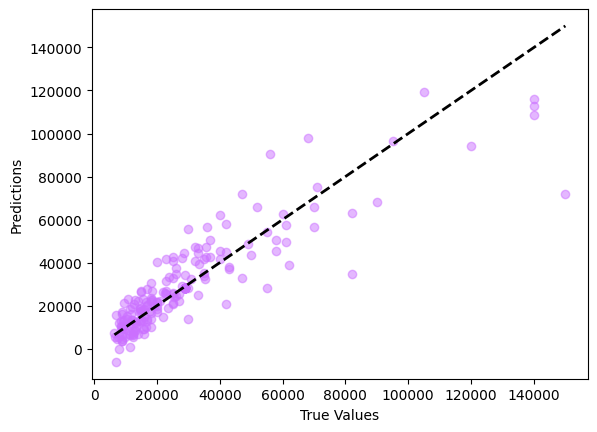

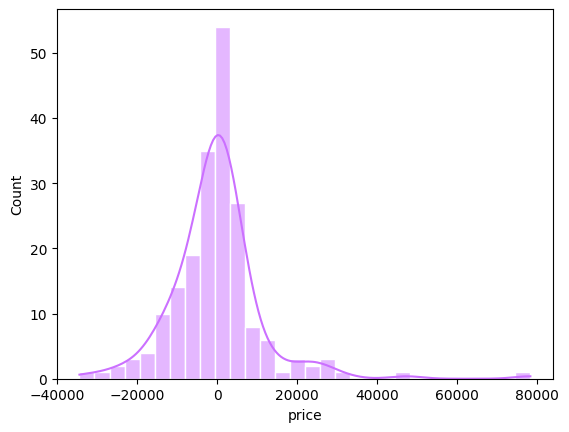

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_cv = RidgeCV(alphas = lambdas, cv = 5).fit(X_train, y_train)
ridge_r2_val = np.mean(cross_val_score(ridge_cv, X_train, y_train, cv = 5, scoring = 'r2'))
ridge_r2_test = r2_score(y_test, ridge_cv.predict(X_test))
ridge_r2_train = r2_score(y_train, ridge_cv.predict(X_train))
print("Train:",ridge_r2_train)
print("Test:",ridge_r2_test)
print("Cross validation:",ridge_r2_val)
linearity(ridge_cv, X_test, y_test)
normality(ridge_cv, X_test, y_test)

## Lasso CV
La regressió de lasso és menys penalitzant quan parlem de complexitat, però en aquest cas podem veure que no ha donat resultats molt diferents de la regressió de ridge. En aquesta hem aplicat els mateixos valors de lambda i de cv que anteriorment, és així que hem obtingut un resultat molt similar. Tant a train com a test, el valor de $R^2$ és molt similar entre ridge i lasso, això també es pot veure representat en les gràfiques, que mostren una recta molt similar en pendent i la mateixa presència d'outliers que fa que el nostre model no funcioni tant bé com podria.

Per últim, podem veure que la regularització no afecta de gran forma a les nostres dades, ja que com hem dit, els resultats son molt similars.

C:\Users\Edu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 855388463.3343124, tolerance: 33025870.97559198
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Edu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 860324873.8594666, tolerance: 33025870.97559198
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Edu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Ob

Train: 0.8105350817659861
Test: 0.785262794949265
Cross validation: 0.7704903210930901


C:\Users\Edu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505787566.2029419, tolerance: 30935554.15160929
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Edu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693427670.884201, tolerance: 30935554.15160929
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Edu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Obj

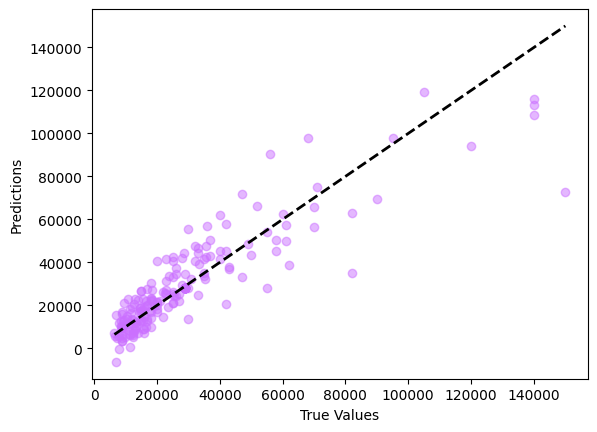

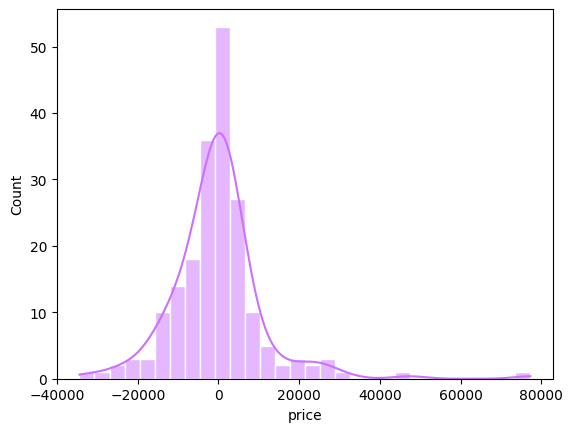

In [36]:
from sklearn.linear_model import LassoCV
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
lasso_cv = LassoCV(alphas = lambdas, cv = 5).fit(X_train, y_train)
lasso_r2_val = np.mean(cross_val_score(lasso_cv, X_train, y_train, cv = 5, scoring = 'r2'))
lasso_r2_test = r2_score(y_test, lasso_cv.predict(X_test))
lasso_r2_train = r2_score(y_train, lasso_cv.predict(X_train))
print("Train:",lasso_r2_train)
print("Test:",lasso_r2_test)
print("Cross validation:",lasso_r2_val)
linearity(lasso_cv, X_test, y_test)
normality(lasso_cv, X_test, y_test)

## Regressió linear
A la regressió linear no li hem d'introduïr cap paràmetre per a optimitzar, però observant els seus resultats, ràpidament veiem la seva similitut amb la resta de regressions. Tant la gràfica de la regressió lineal com la de normalitat del model son molt semblants a les dels dos models anteriors, fent-nos veure que en aquest cas, fins i tot podriem haver prescindit de la regularització que ens oferien ridge i lasso, ja que emprant una regressió linear obtenim resultats lleugerament millors que en la resta de casos.

Mean squared error (train): 104536028.93
Mean squared error (test): 134246725.75
R2 (train): 0.81
R2 (test): 0.79


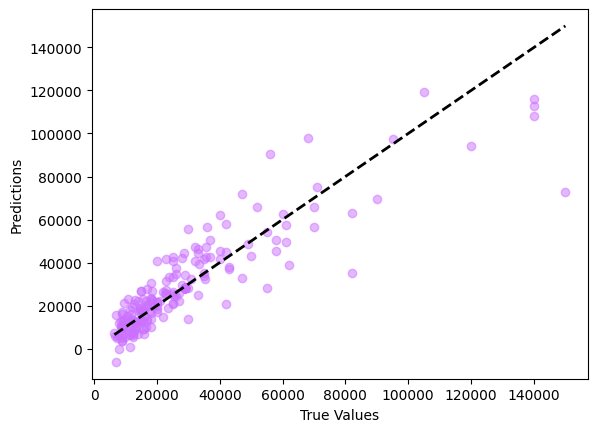

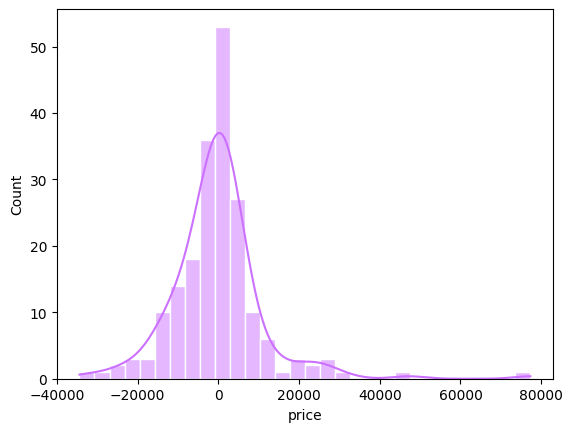

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

lr = model.fit(X_train, y_train)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Mean squared error (train): {mse_train:.2f}")
print(f"Mean squared error (test): {mse:.2f}")
print(f"R2 (train): {r2_train:.2f}")
print(f"R2 (test): {r2:.2f}")
linearity(model, X_test, y_test)
normality(model, X_test, y_test)

## Visualització dels pesos
Finalment podem comparar els pesos per a observar les diferències a nivell de funcionament intern dins del models.

El canvi més destacable és que a la regressió linear, molts dels valors als quals aquesta els hi otorga poc pes, son otorgats amb molt més tant a ridge com a lasso, aquí podem observar la diferència causada pel paràmetre de regularització que penalitza la complexitat. A més d'això, podem observar que en els models que regularitzen, es dona un gran pes a que el sistema operatiu del telefon sigui android, i que la marca d'aquest sigui Apple, aquest últim sent exclusiu de lasso, ja que en ridge mostra un pes molt més baix. Dins d'aquests dos mètodes, les diferències de pesos no son gaire significatives, donant a entendre que no feia falta aplicar una regularització tant exhaustiva com és ridge. 

<Axes: >

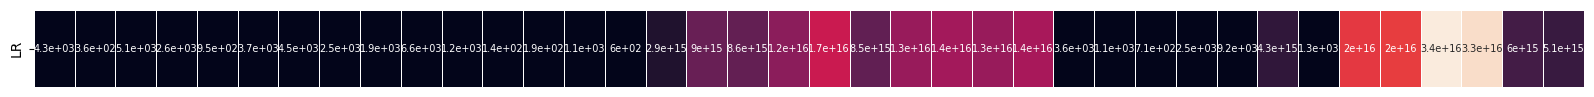

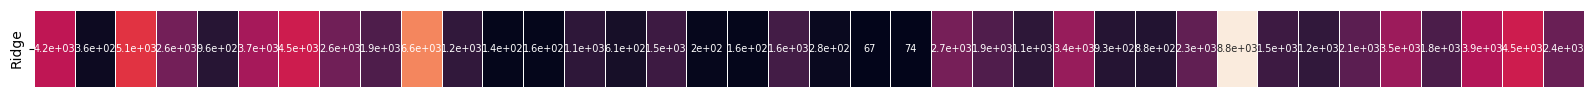

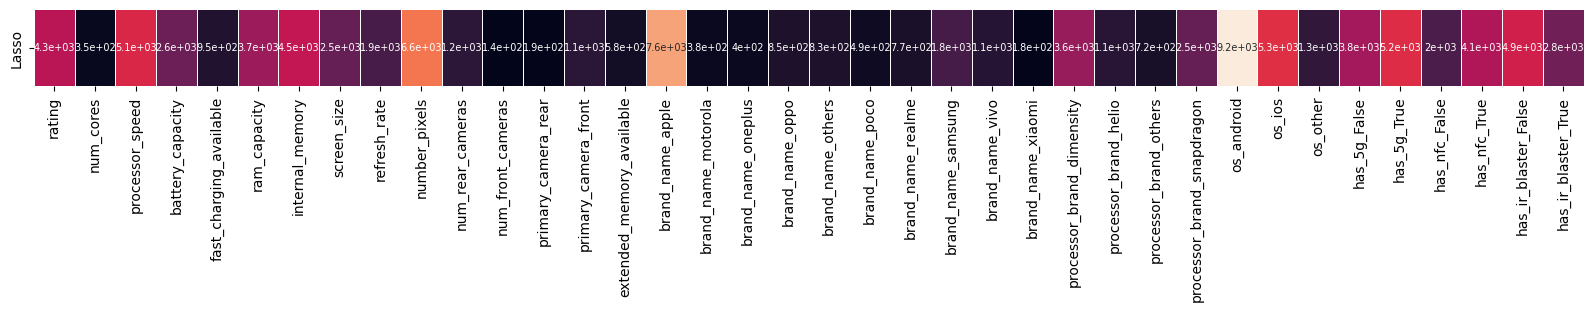

In [40]:
weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False, annot_kws={"size": 7})

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False, annot_kws={"size": 7})

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True, annot_kws={"size": 7})

# Xarxes neuronals

In [177]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score

In [104]:
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['R2Score']
  val_accuracy = history.history['val_R2Score']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training R2 Score')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation R2 Score')
  axes[1].set_title('Training and Validation R2 Score')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('R2 Score')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()

## Primera iteració

c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


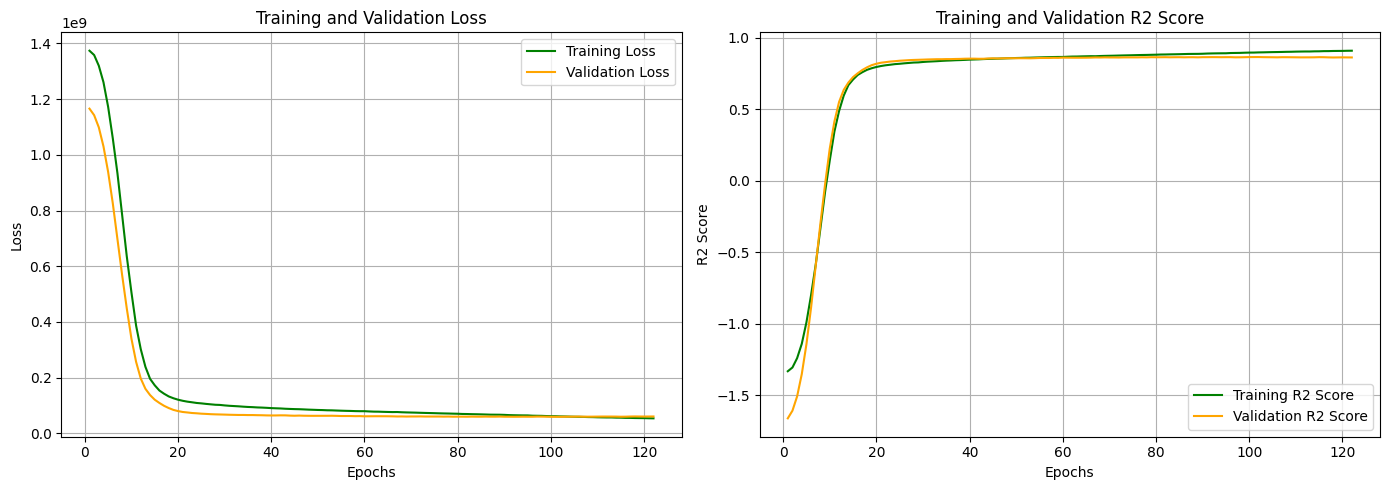

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


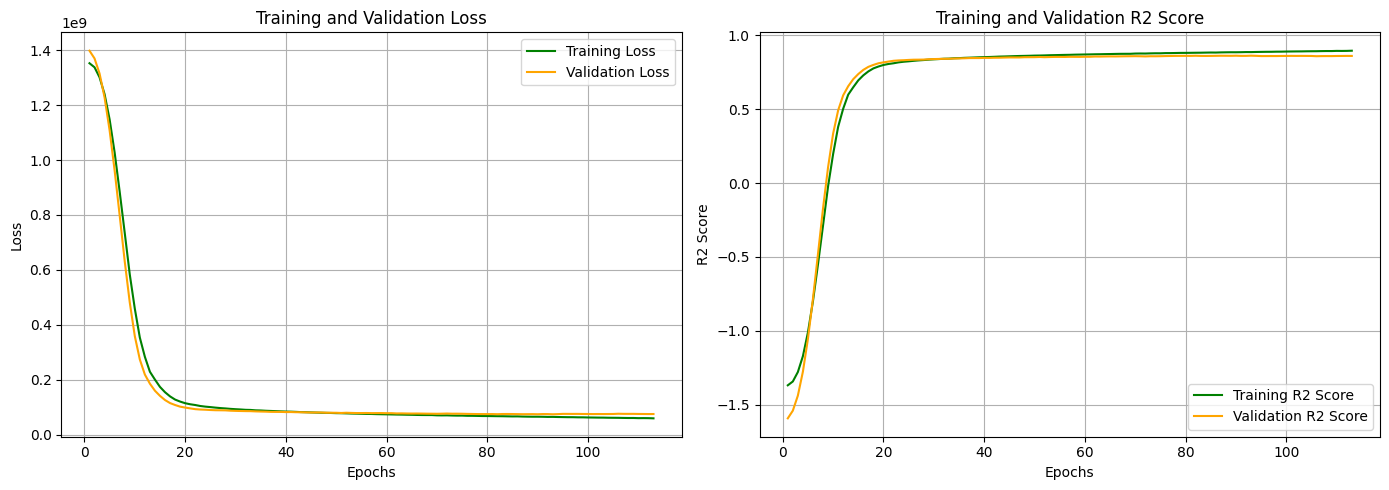

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


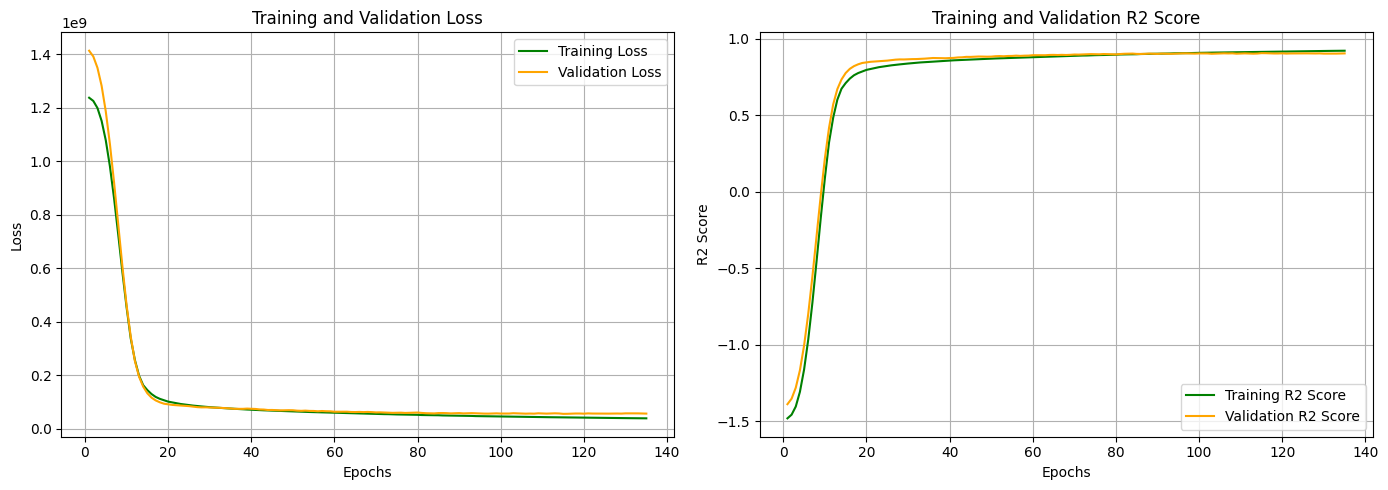

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


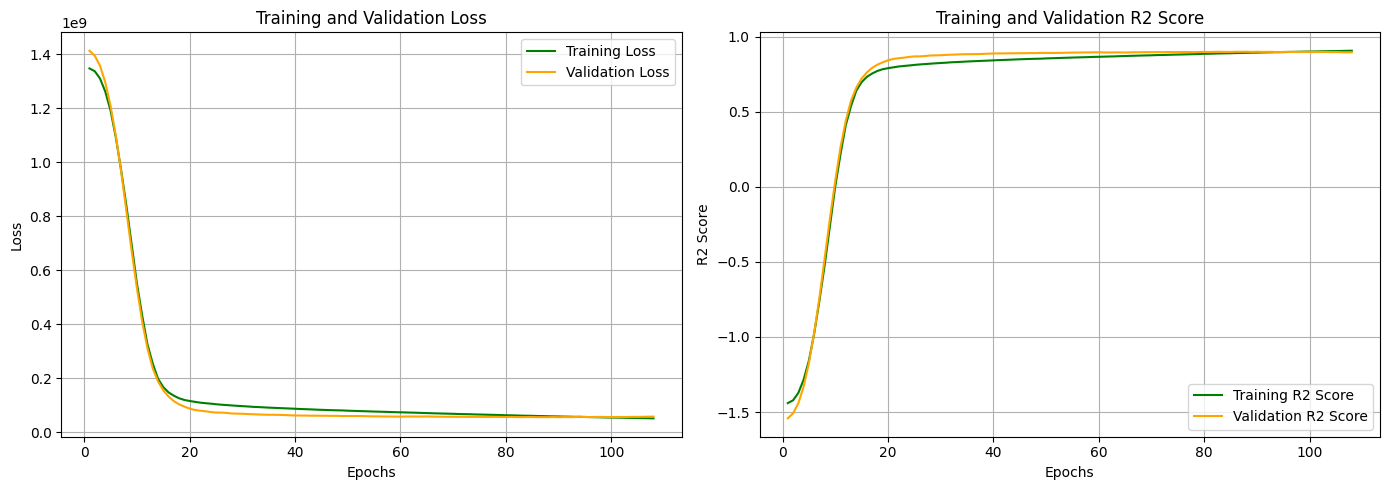

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


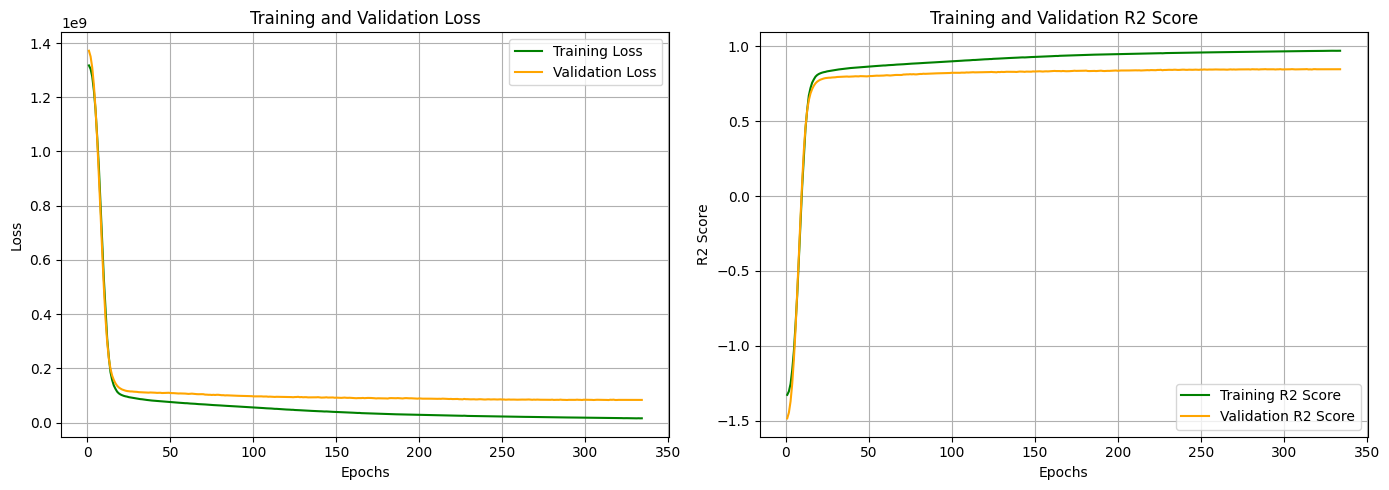

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
Training MSE: 52080750.0810
Validation MSE: 98334489.0495
Training R-squared: 0.9056
Validation R-squared: 0.8215


In [133]:
from sklearn.model_selection import KFold

num_folds = 5

train_mse_cv = []
val_mse_cv = []
train_r2_cv = []
val_r2_cv = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

learning_rate = 0.1

batch_size=64
num_epochs=1000

for train_index, test_index in kf.split(X_train):
    model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='linear') 
    ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['R2Score'])

    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv,y_val_cv= y_train.iloc[train_index],y_train.iloc[test_index]

    history = model.fit(X_train_cv, y_train_cv, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, verbose=0, callbacks=[early_stopping])

    plot_curves(history)

    y_train_pred = model.predict(X_train_cv)
    y_val_pred = model.predict(X_val_cv)

    train_mse_cv.append(mean_squared_error(y_train_cv, y_train_pred))
    val_mse_cv.append(mean_squared_error(y_val_cv, y_val_pred))

    train_r2_cv.append(r2_score(y_train_cv, y_train_pred))
    val_r2_cv.append(r2_score(y_val_cv, y_val_pred))


print('Training MSE: {:.4f}'.format(np.mean(train_mse_cv)))
print('Validation MSE: {:.4f}'.format(np.mean(val_mse_cv)))
print('Training R-squared: {:.4f}'.format(np.mean(train_r2_cv)))
print('Validation R-squared: {:.4f}'.format(np.mean(val_r2_cv)))

## Segona iteració

c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


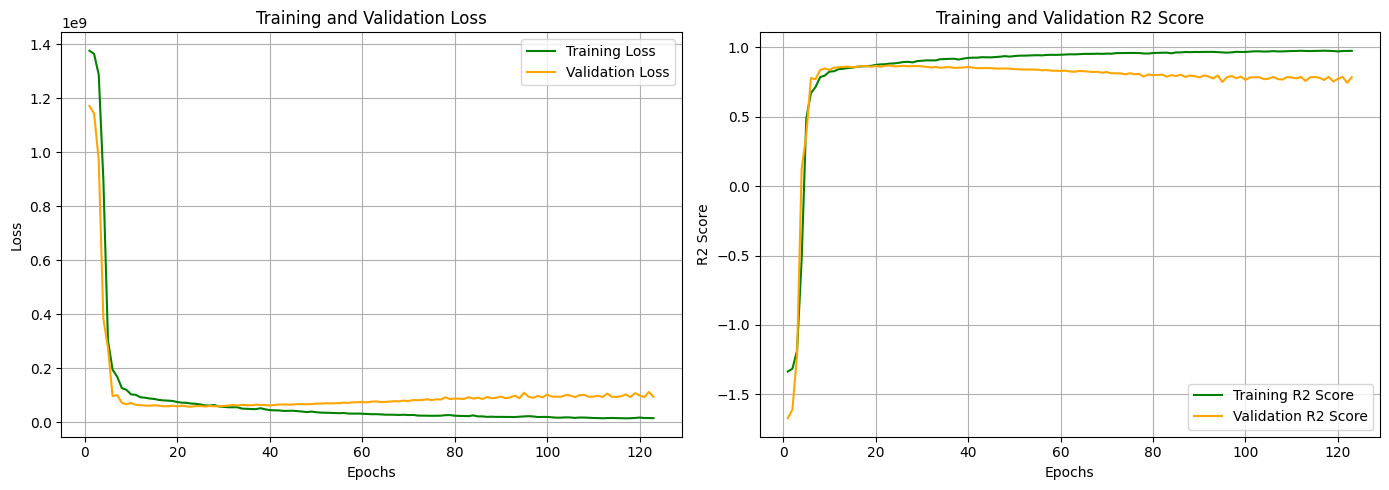

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


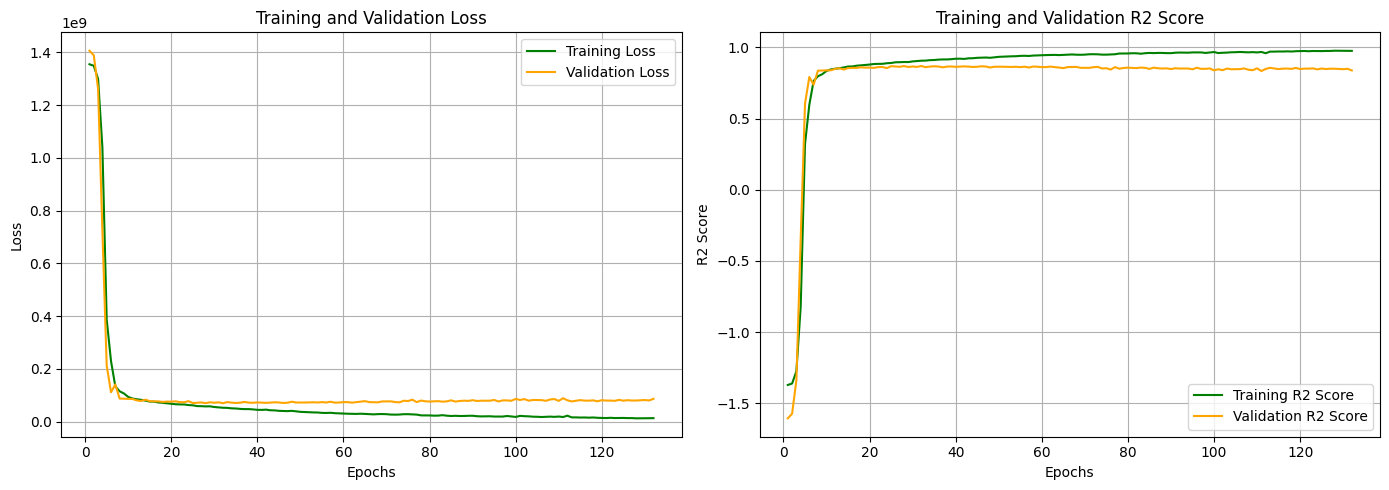

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


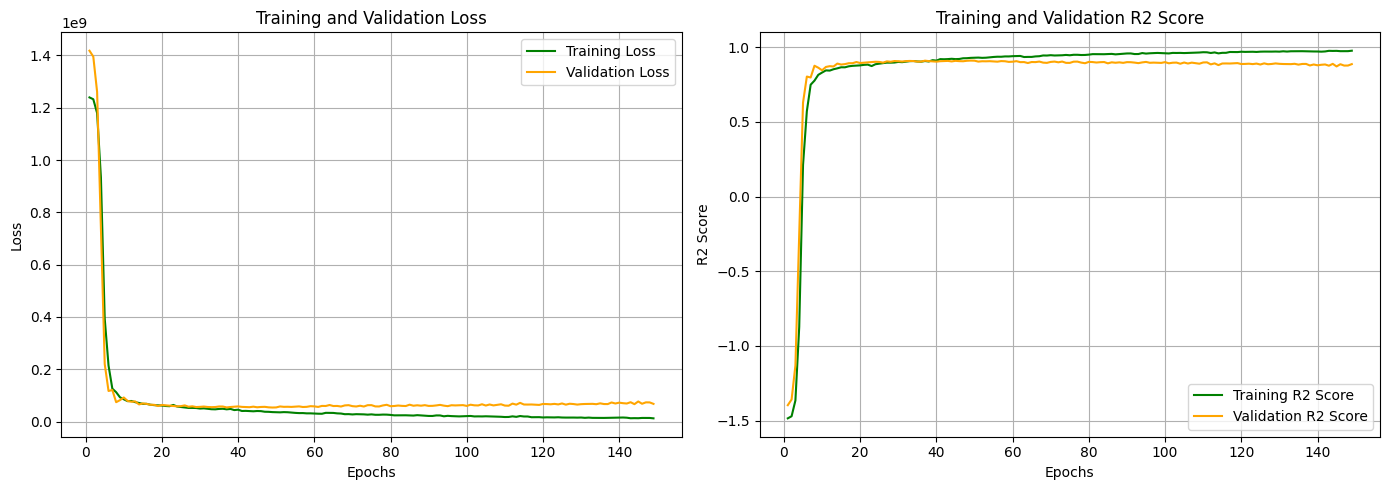

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


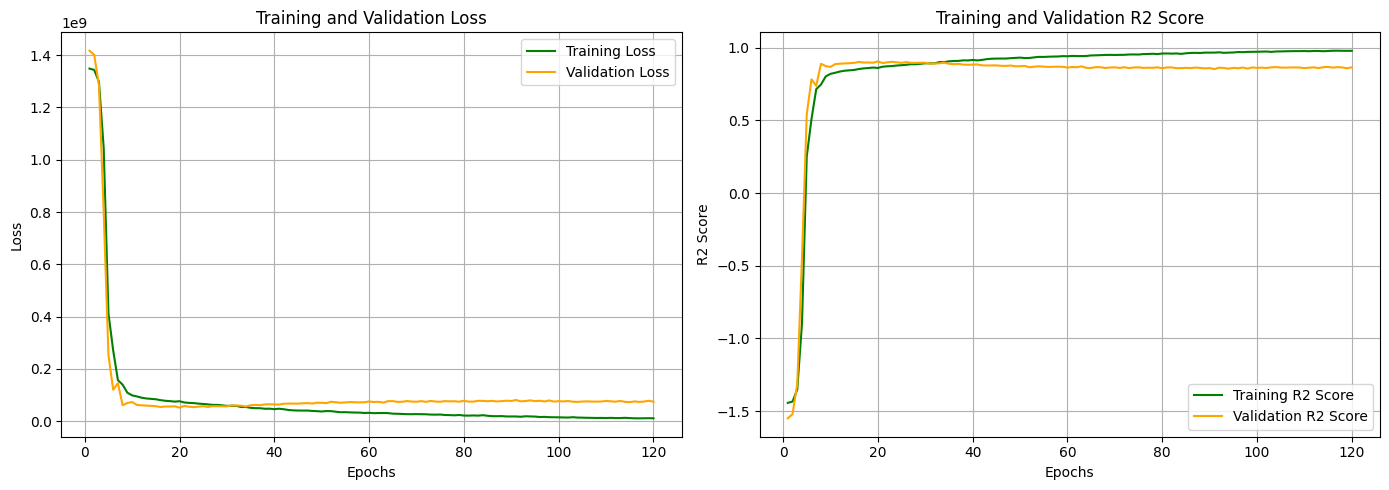

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


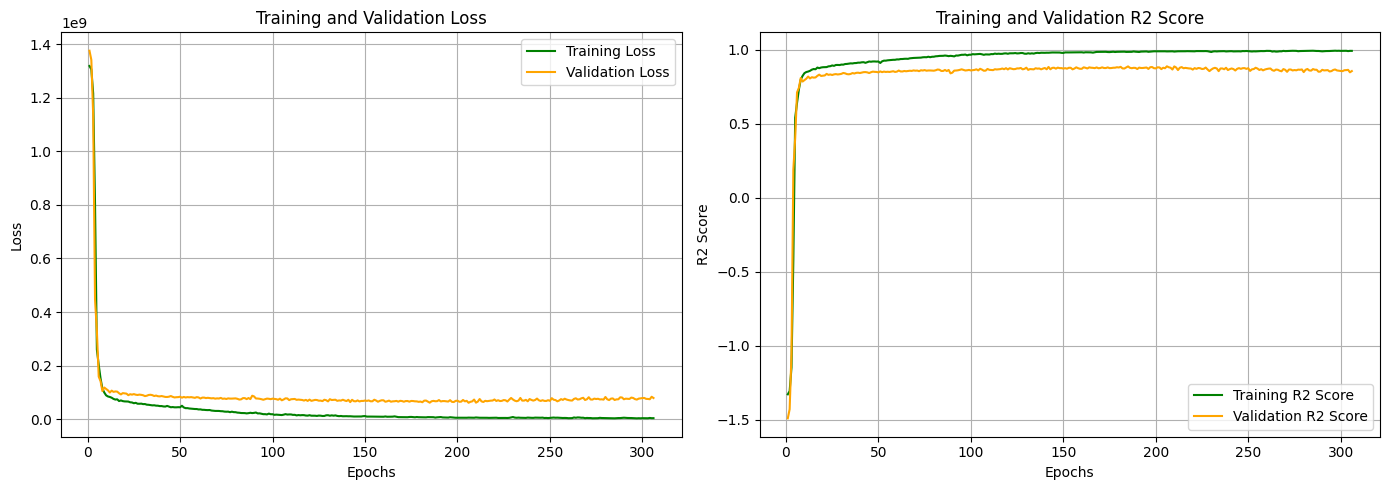

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training MSE: 48499410.6166
Validation MSE: 87477473.0357
Training R-squared: 0.9121
Validation R-squared: 0.8412


In [134]:
from sklearn.model_selection import KFold

num_folds = 5

train_mse_cv = []
val_mse_cv = []
train_r2_cv = []
val_r2_cv = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

learning_rate = 0.01

batch_size=64
num_epochs=2000

for train_index, test_index in kf.split(X_train):
    model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear') 
    ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['R2Score'])

    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv,y_val_cv= y_train.iloc[train_index],y_train.iloc[test_index]

    history = model.fit(X_train_cv, y_train_cv, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, verbose=0, callbacks=[early_stopping])

    plot_curves(history)

    y_train_pred = model.predict(X_train_cv)
    y_val_pred = model.predict(X_val_cv)

    train_mse_cv.append(mean_squared_error(y_train_cv, y_train_pred))
    val_mse_cv.append(mean_squared_error(y_val_cv, y_val_pred))

    train_r2_cv.append(r2_score(y_train_cv, y_train_pred))
    val_r2_cv.append(r2_score(y_val_cv, y_val_pred))


print('Training MSE: {:.4f}'.format(np.mean(train_mse_cv)))
print('Validation MSE: {:.4f}'.format(np.mean(val_mse_cv)))
print('Training R-squared: {:.4f}'.format(np.mean(train_r2_cv)))
print('Validation R-squared: {:.4f}'.format(np.mean(val_r2_cv)))

## Tercera iteració

c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


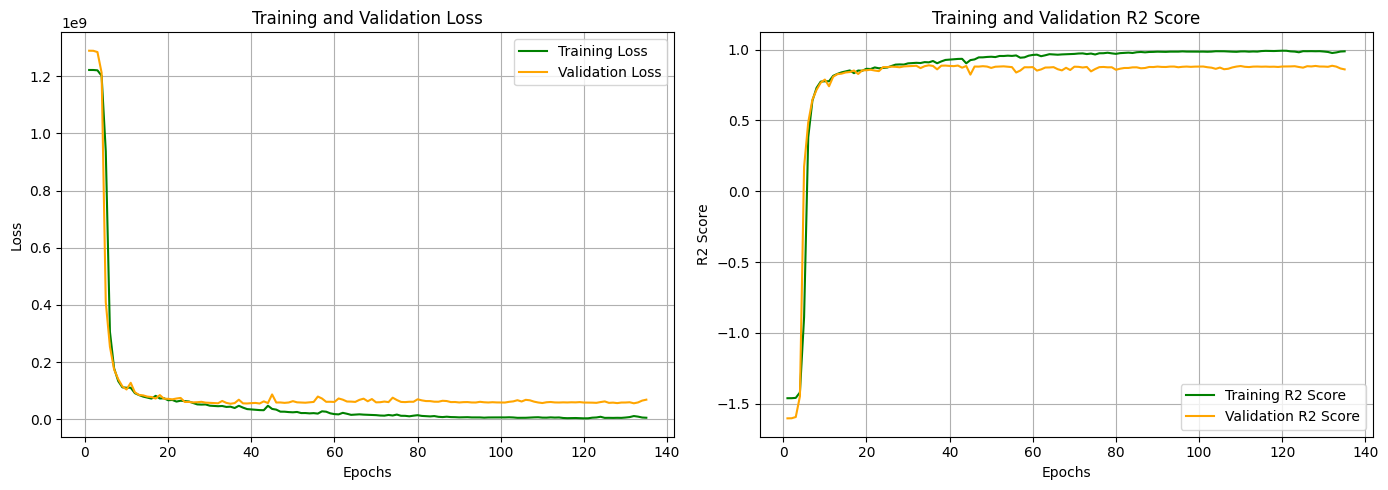

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


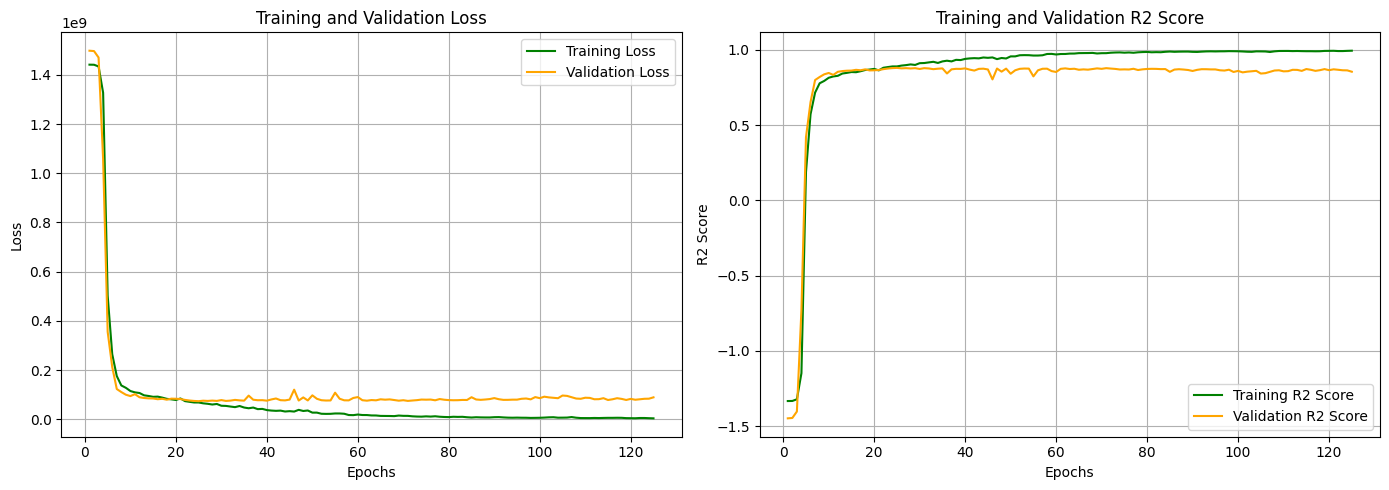

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


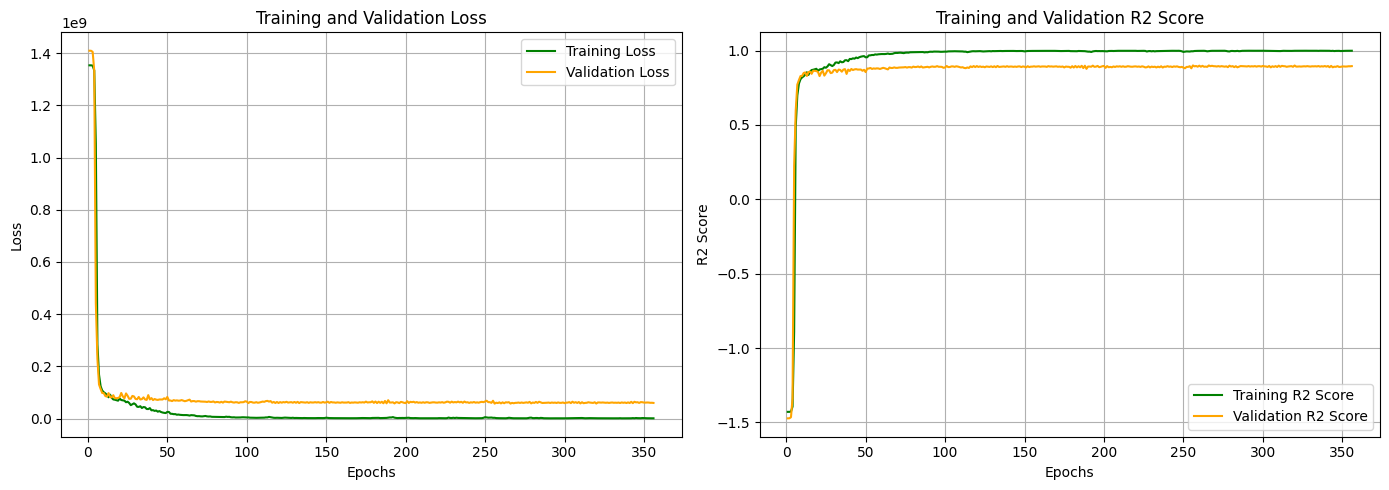

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


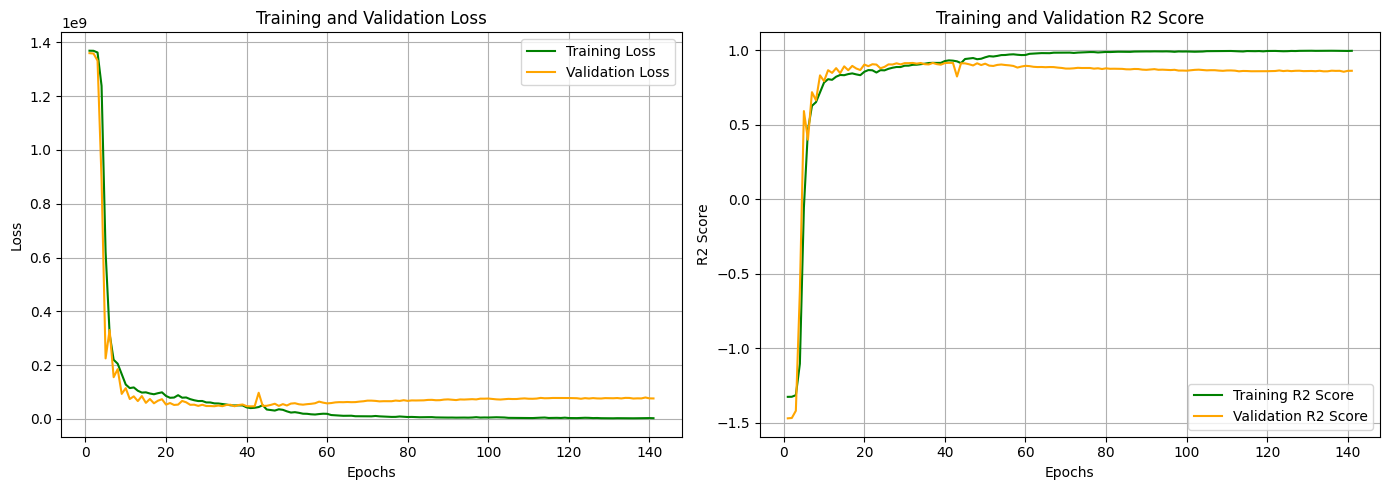

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


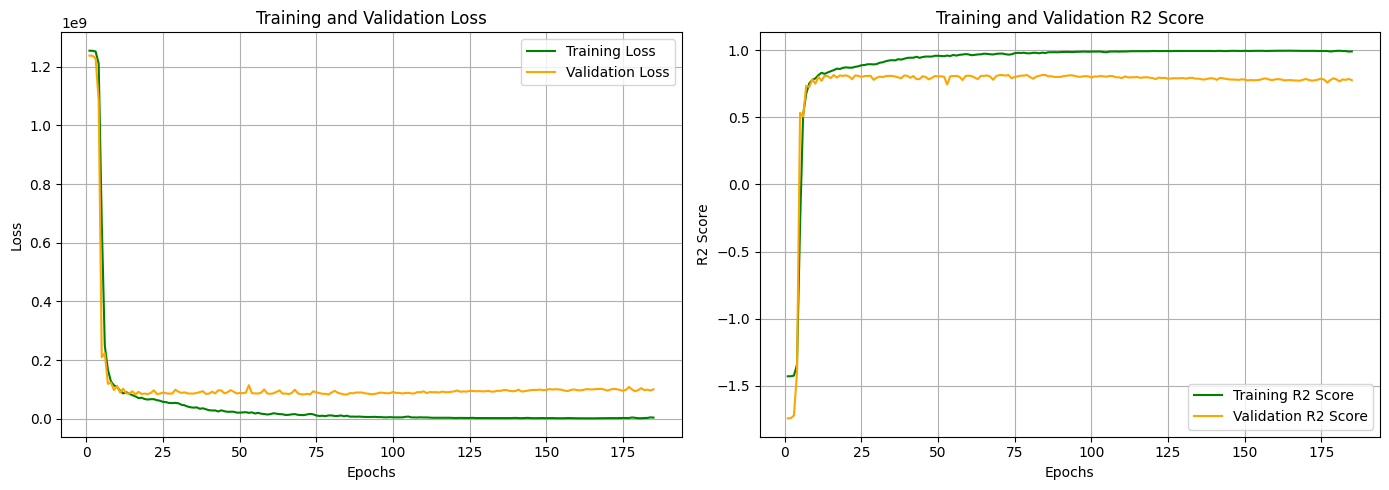

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training MSE: 37158686.4310
Validation MSE: 82148155.1503
Training R-squared: 0.9334
Validation R-squared: 0.8415


In [137]:
from sklearn.model_selection import KFold

num_folds = 5

train_mse_cv = []
val_mse_cv = []
train_r2_cv = []
val_r2_cv = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=64)

learning_rate = 0.001

batch_size=64
num_epochs=2000

for train_index, test_index in kf.split(X_train):
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(1, activation='linear') 
    ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['R2Score'])

    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv,y_val_cv= y_train.iloc[train_index],y_train.iloc[test_index]

    history = model.fit(X_train_cv, y_train_cv, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, verbose=0, callbacks=[early_stopping])

    plot_curves(history)

    y_train_pred = model.predict(X_train_cv)
    y_val_pred = model.predict(X_val_cv)

    train_mse_cv.append(mean_squared_error(y_train_cv, y_train_pred))
    val_mse_cv.append(mean_squared_error(y_val_cv, y_val_pred))

    train_r2_cv.append(r2_score(y_train_cv, y_train_pred))
    val_r2_cv.append(r2_score(y_val_cv, y_val_pred))


print('Training MSE: {:.4f}'.format(np.mean(train_mse_cv)))
print('Validation MSE: {:.4f}'.format(np.mean(val_mse_cv)))
print('Training R-squared: {:.4f}'.format(np.mean(train_r2_cv)))
print('Validation R-squared: {:.4f}'.format(np.mean(val_r2_cv)))

## Quarta iteració

c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


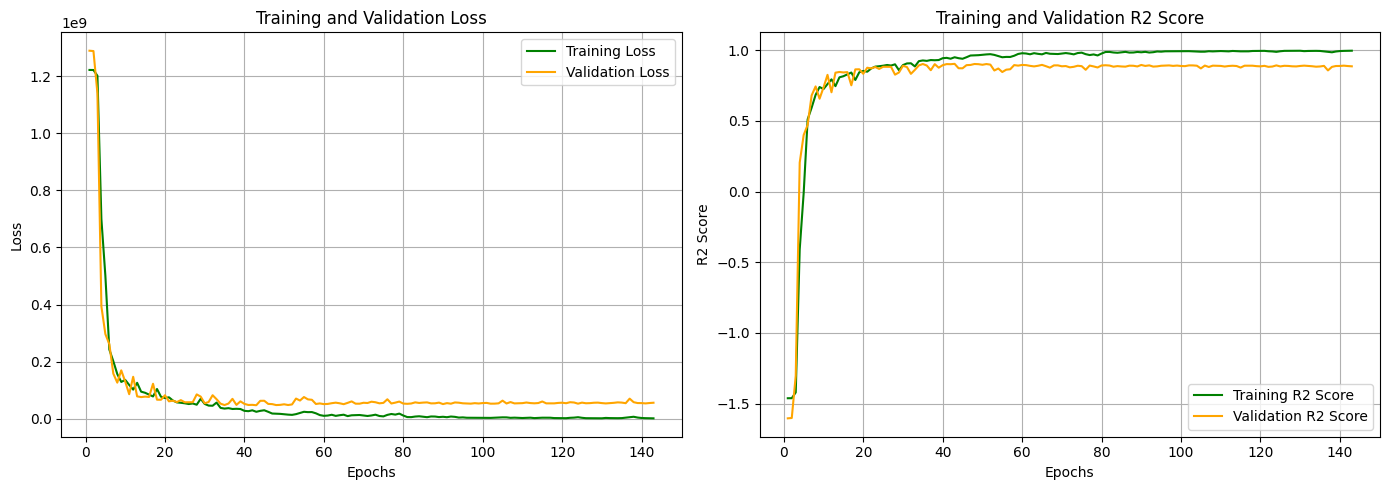

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


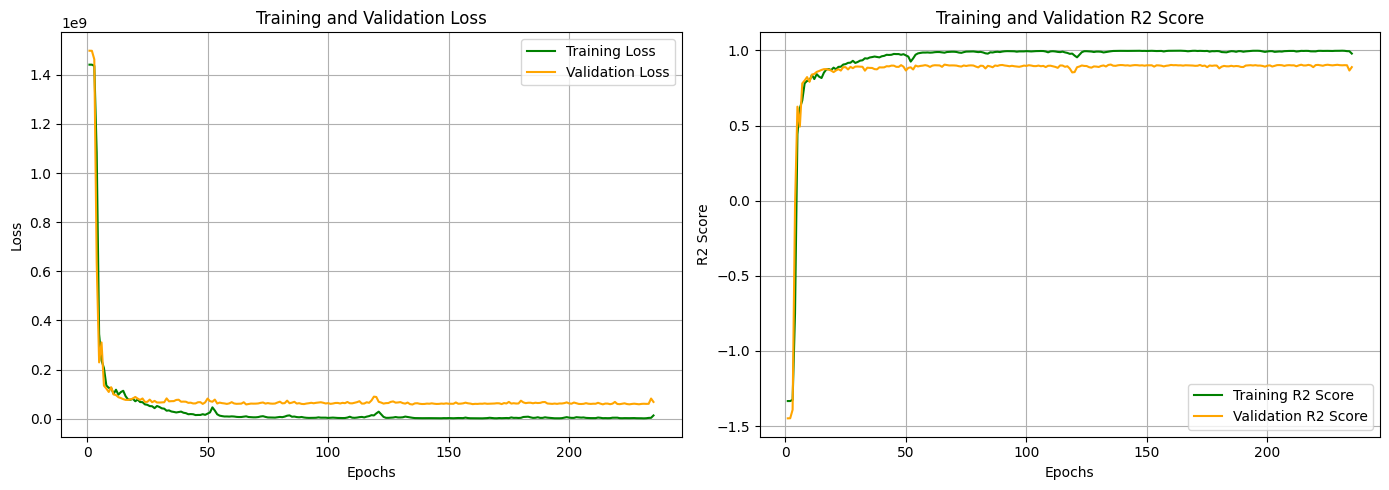

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


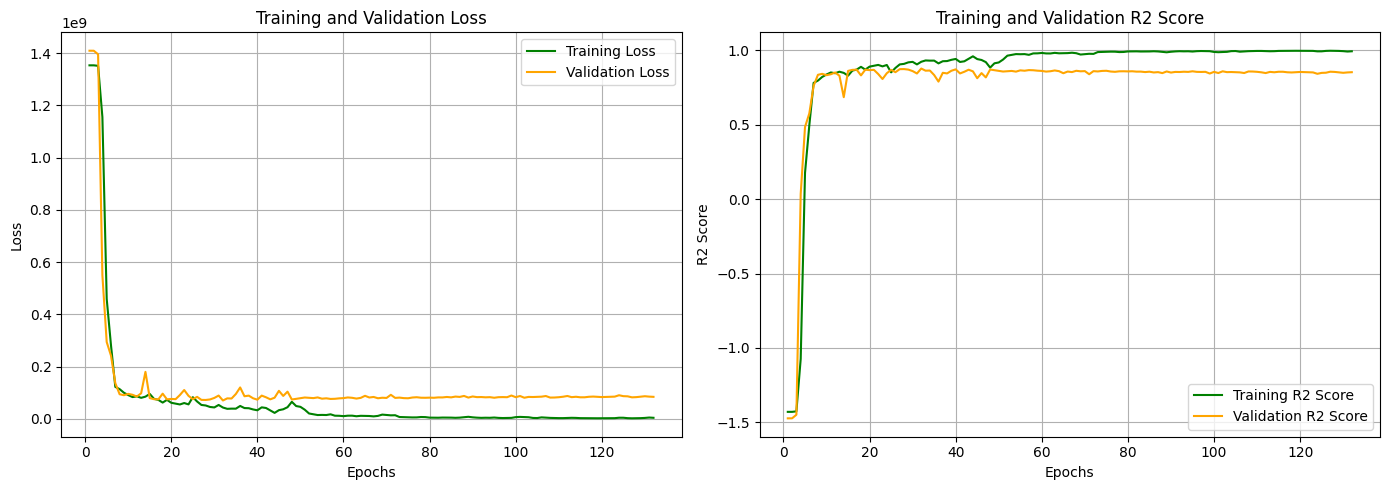

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


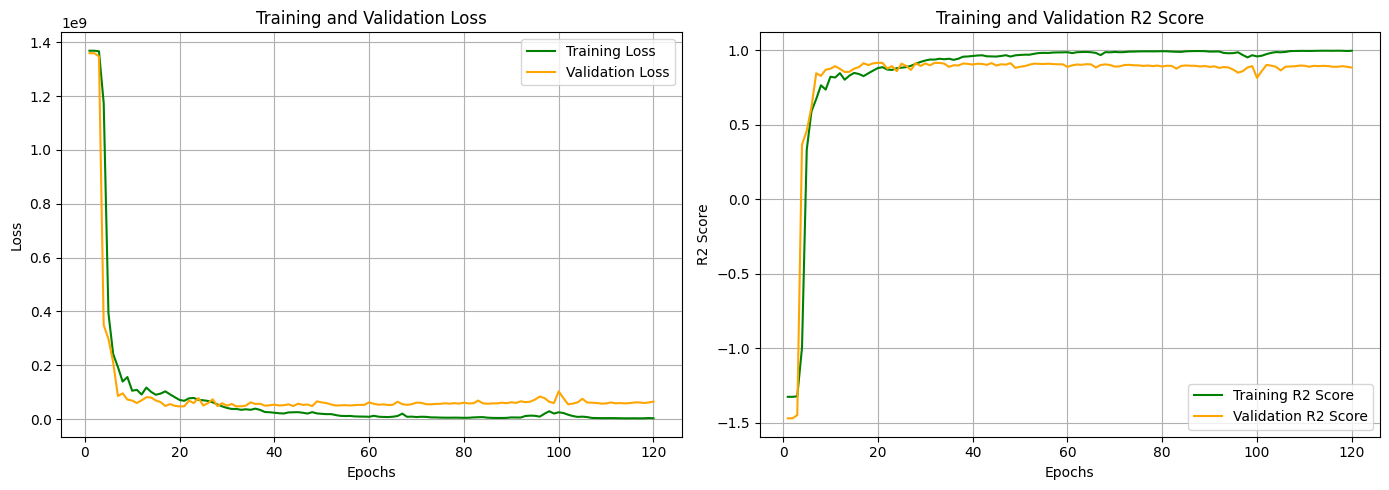

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


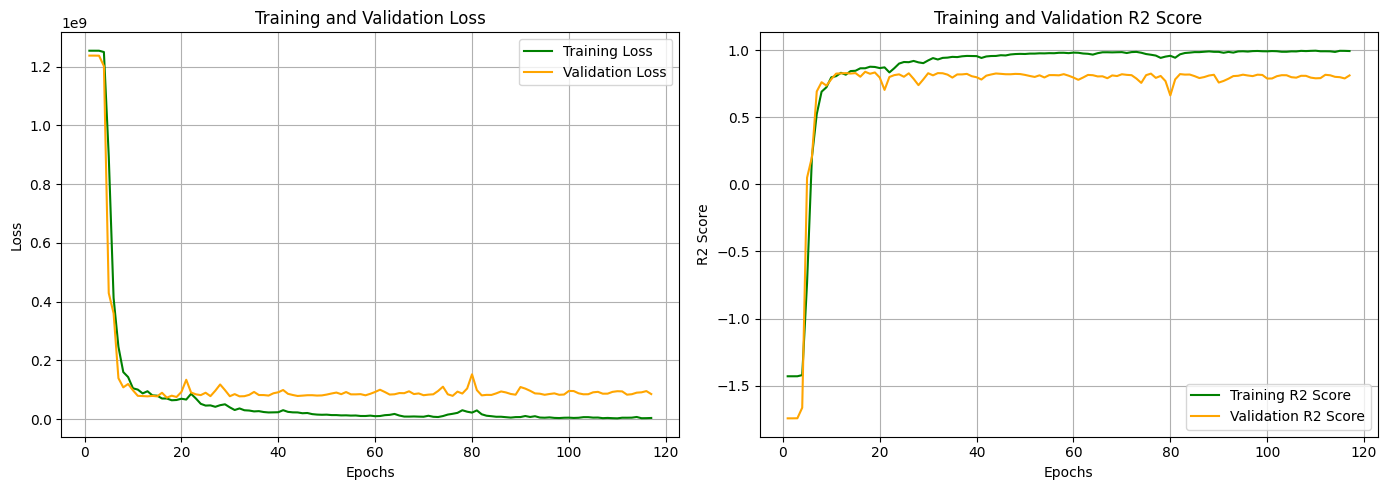

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training MSE: 42094484.7550
Validation MSE: 87685566.1737
Training R-squared: 0.9222
Validation R-squared: 0.8280


In [140]:
from sklearn.model_selection import KFold

num_folds = 5

train_mse_cv = []
val_mse_cv = []
train_r2_cv = []
val_r2_cv = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=64)

learning_rate = 0.001

batch_size=64
num_epochs=2000

for train_index, test_index in kf.split(X_train):
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(1, activation='linear') 
    ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['R2Score'])

    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv,y_val_cv= y_train.iloc[train_index],y_train.iloc[test_index]

    history = model.fit(X_train_cv, y_train_cv, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, verbose=0, callbacks=[early_stopping])

    plot_curves(history)

    y_train_pred = model.predict(X_train_cv)
    y_val_pred = model.predict(X_val_cv)

    train_mse_cv.append(mean_squared_error(y_train_cv, y_train_pred))
    val_mse_cv.append(mean_squared_error(y_val_cv, y_val_pred))

    train_r2_cv.append(r2_score(y_train_cv, y_train_pred))
    val_r2_cv.append(r2_score(y_val_cv, y_val_pred))


print('Training MSE: {:.4f}'.format(np.mean(train_mse_cv)))
print('Validation MSE: {:.4f}'.format(np.mean(val_mse_cv)))
print('Training R-squared: {:.4f}'.format(np.mean(train_r2_cv)))
print('Validation R-squared: {:.4f}'.format(np.mean(val_r2_cv)))

## Test del model final (iteració 3)

c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


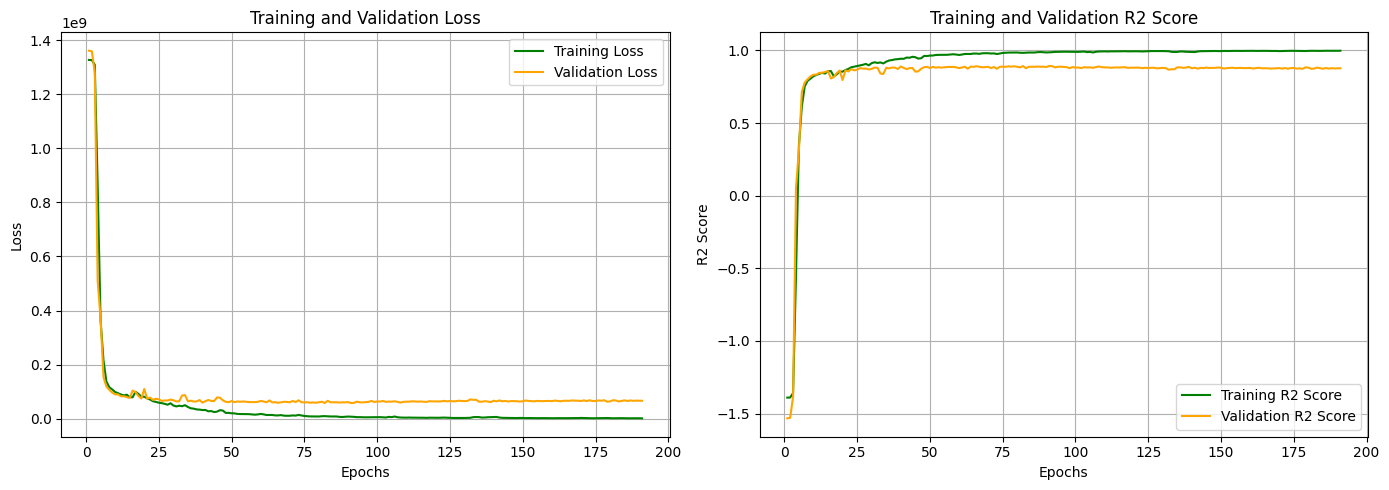

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


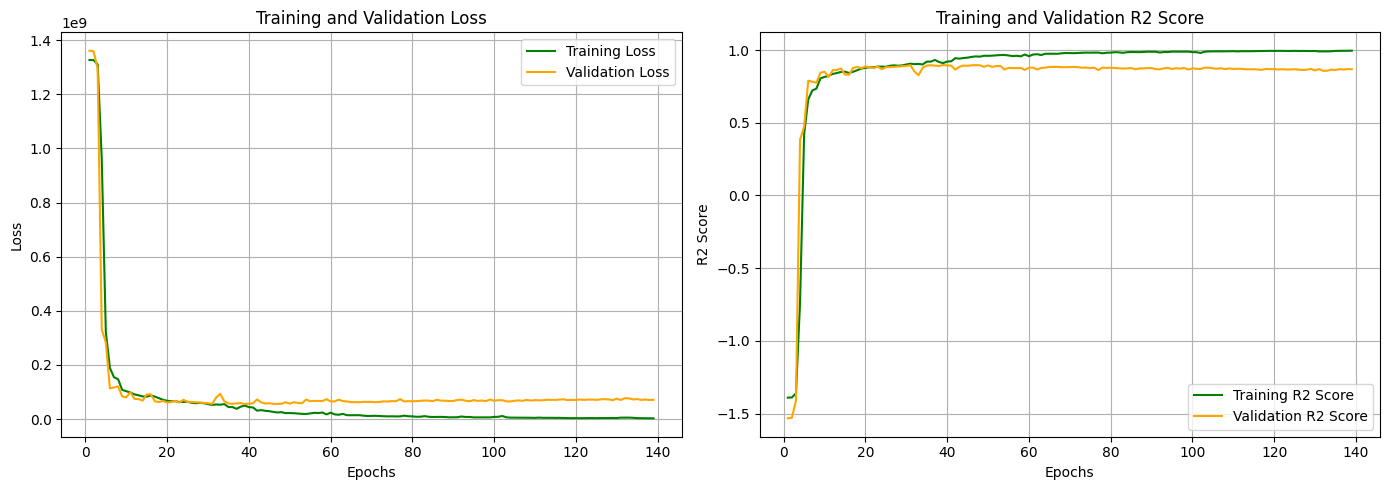

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


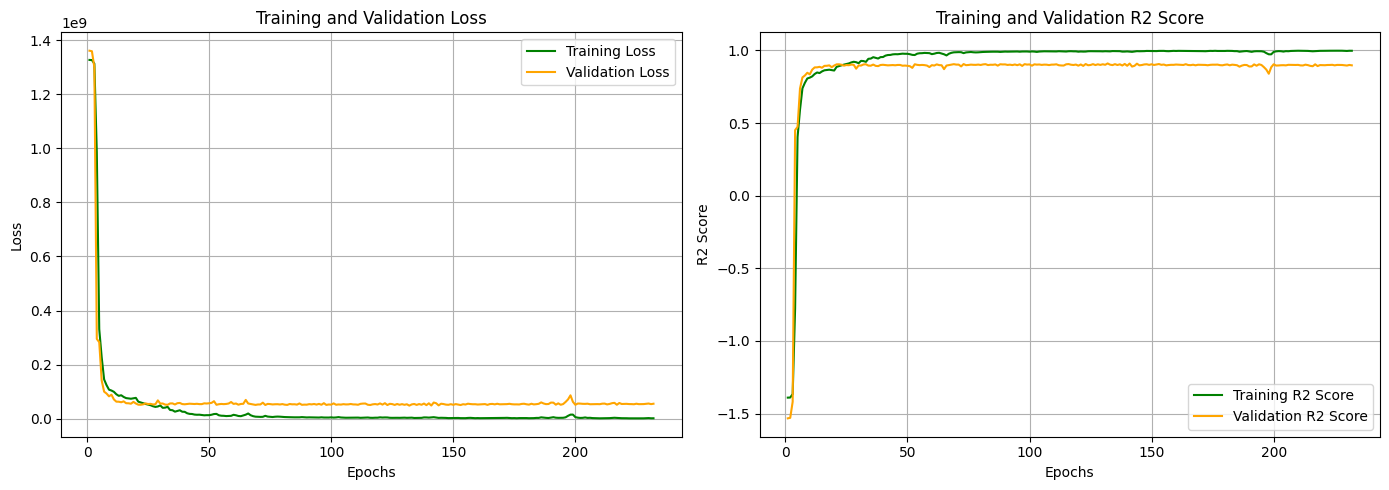

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


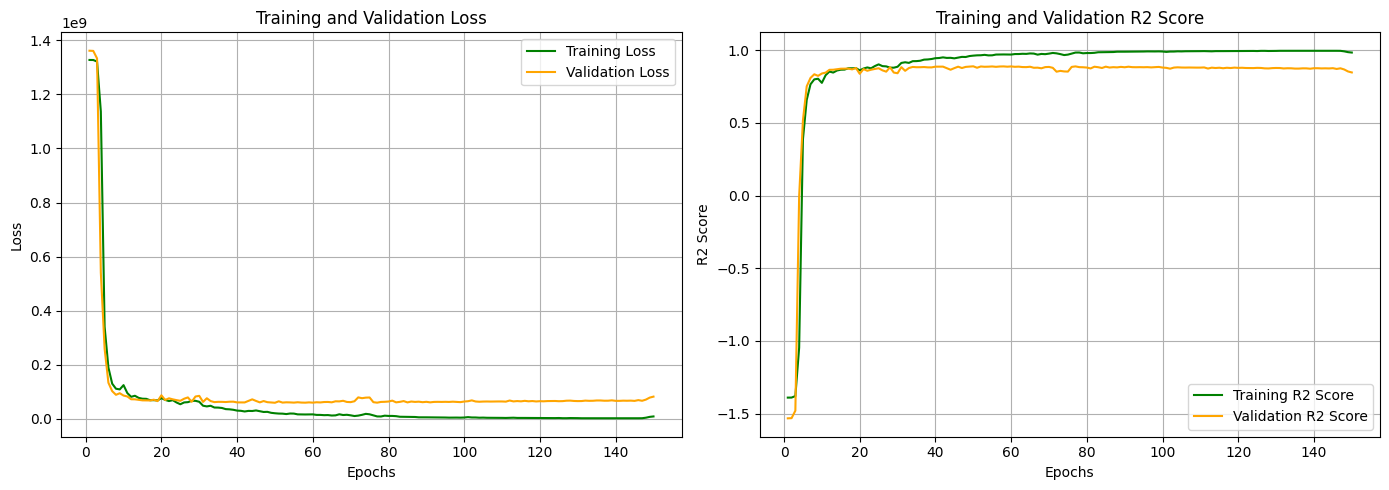

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


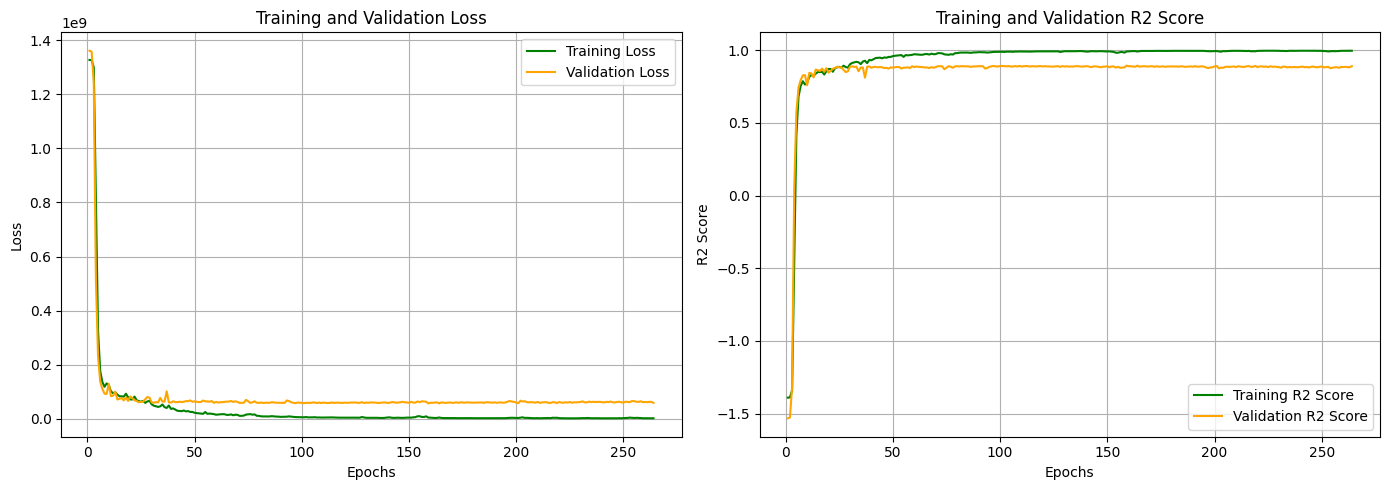

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


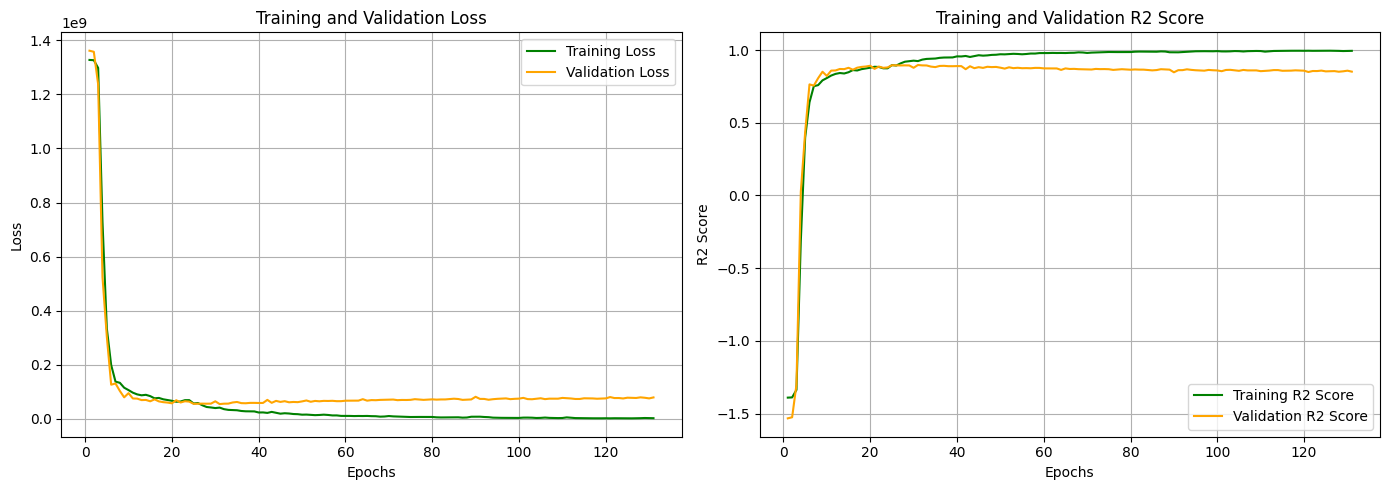

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


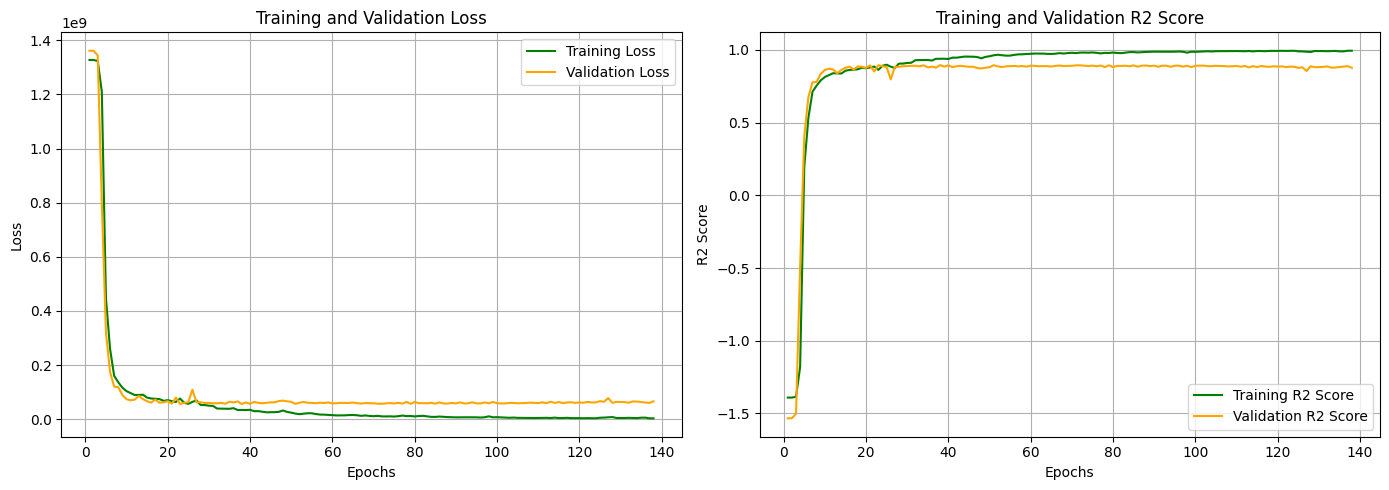

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


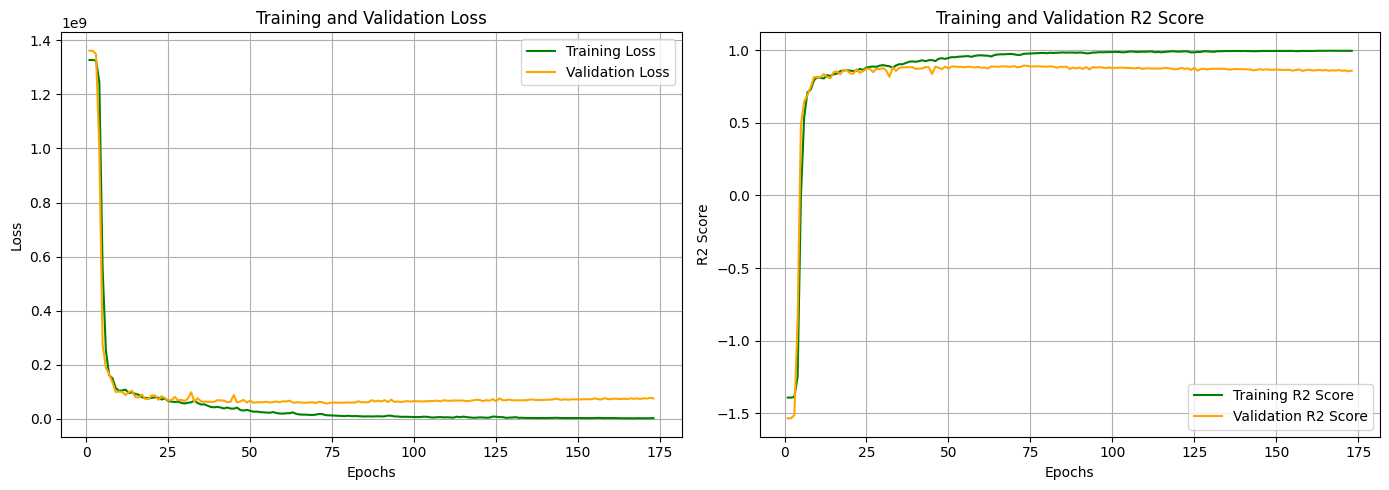

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


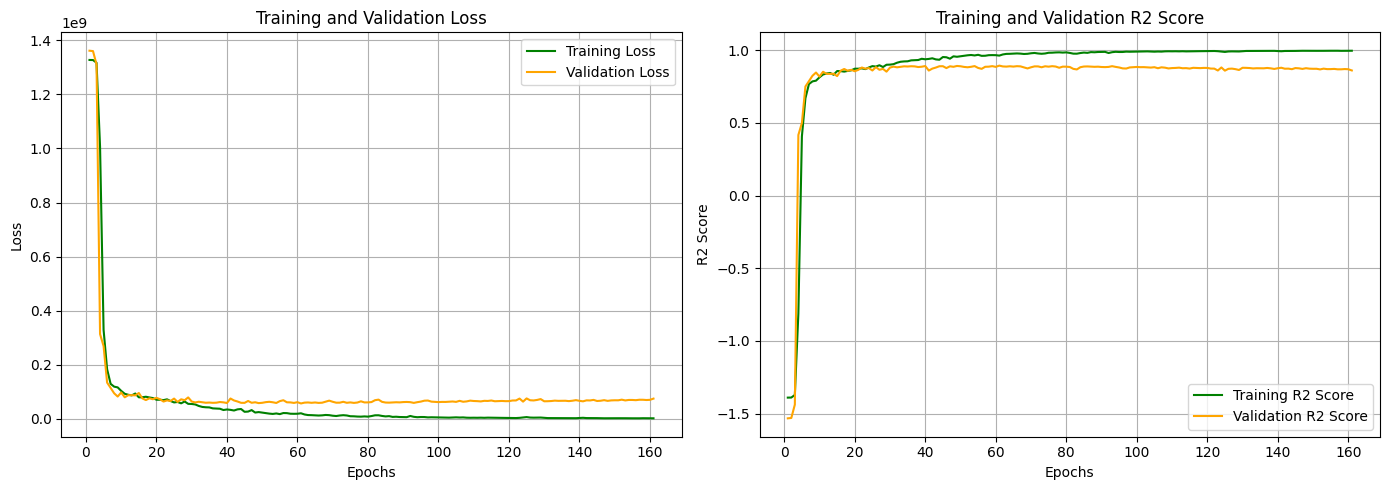

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\maxmg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


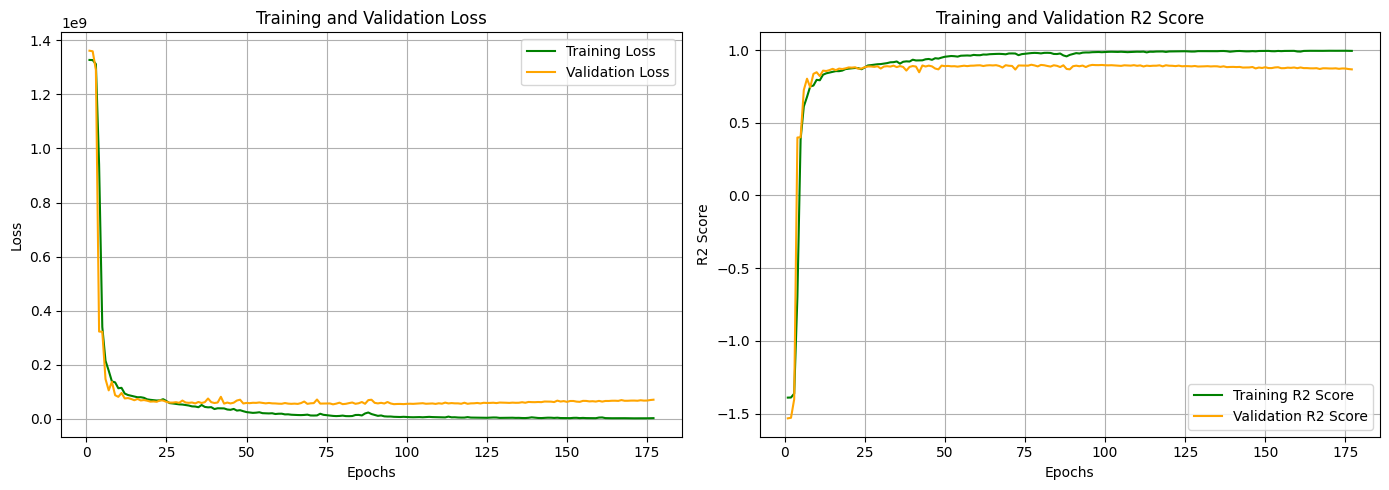

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
Average Training MSE: 24358227.9482
Average Testing MSE: 87423690.1173
Average Training R-squared: 0.9559
Average Testing R-squared: 0.8603
Minimum Testing R-squared: 0.8177
Maximum Testing R-squared: 0.8845


In [ ]:
learning_rate = 0.001

train_mse_total = []
test_mse_total = []

train_r2_total = []
test_r2_total = []

batch_size=64
num_epochs=2000

for i in range(10):
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(1, activation='linear') 
    ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['R2Score'])

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, verbose=0, callbacks=[early_stopping])

    plot_curves(history)

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_pred)

    train_mse_total.append(train_mse)
    test_mse_total.append(test_mse)

    train_r2_total.append(train_r2)
    test_r2_total.append(test_r2)

print('Average Training MSE: {:.4f}'.format(np.mean(train_mse_total)))
print('Average Testing MSE: {:.4f}'.format(np.mean(test_mse_total)))
print('Average Training R-squared: {:.4f}'.format(np.mean(train_r2_total)))
print('Average Testing R-squared: {:.4f}'.format(np.mean(test_r2_total)))
print('Minimum Testing R-squared: {:.4f}'.format(np.min(test_r2_total)))
print('Maximum Testing R-squared: {:.4f}'.format(np.max(test_r2_total)))